- VAE test for code reviewed
- comparison alpha value

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
import tensorflow as tf
import seaborn as sns

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, plot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from importlib import reload
import generator_vae
reload(plot)
reload(generator_vae)

from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [4]:
from generator_vae import BatchGenerator

# Loading the trained VAE

In [44]:
vae_lsst_r_band_conv, encoder_R, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v16/mse/',1, folder = True)

In [6]:
vae_lsst_conv, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v11/',6, folder= True) # v7 OK

In [7]:
vae_lsst_euclid_conv, encoder_LSST_EUCLID, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v8/mse/',10, folder = True)

# Generators

In [7]:
list_of_samples_old=['/sps/lsst/users/barcelin/data/single/changing_lsst_PSF/wrong_Euclid_Nexp_not_independant/galaxies_COSMOS_test_v3.npy']#independant/galaxies_COSMOS_1_v5.npy']#

In [8]:
list_of_samples_new=['/sps/lsst/users/barcelin/data/single/changing_lsst_PSF/independant/galaxies_test_v5.npy']#independant/galaxies_COSMOS_1_v5.npy']#

In [9]:
scale_radius = np.load('/sps/lsst/users/barcelin/data/single/changing_lsst_PSF/independant/scale_radius_test_v5.npy', mmap_mode = 'c')

In [ ]:
SNR = np.load('/sps/lsst/users/barcelin/data/single/changing_lsst_PSF/independant/SNR_test_v5.npy')

In [10]:
bands_r = [6]

In [11]:
batch_gen_old = BatchGenerator(bands_r, list_of_samples_old, total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius,  trainval_or_test = 'training', noisy = True)

NameError: name 'list_of_samples_old' is not defined

In [13]:
batch_gen_new = BatchGenerator(bands_r, list_of_samples_new, total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius,SNR = SNR,  trainval_or_test = 'training', noisy = True)

In [14]:
bands_lsst = [4,5,6,7,8,9]

In [15]:
batch_gen_lsst = BatchGenerator(bands_lsst, list_of_samples_new,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius, SNR = SNR, trainval_or_test = 'test', noisy = True)#list_of_redshift,

In [16]:
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

In [17]:
batch_gen_lsst_euclid = BatchGenerator(bands_lsst_euclid, list_of_samples_new,total_sample_size=10000, batch_size= 100, size_of_lists = 10000, scale_radius = scale_radius, SNR = SNR, trainval_or_test = 'test', noisy = True)#list_of_redshift,

In [18]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot vae R band only

In [155]:
input_vae_old = batch_gen_old.__getitem__(2)
input_vae_new = batch_gen_new.__getitem__(2)

In [156]:
input_vae_old[0].shape, input_vae_old[1].shape, input_vae_new[0].shape, input_vae_new[1].shape

((100, 64, 64, 1), (100, 64, 64, 1), (100, 64, 64, 1), (100, 64, 64, 1))

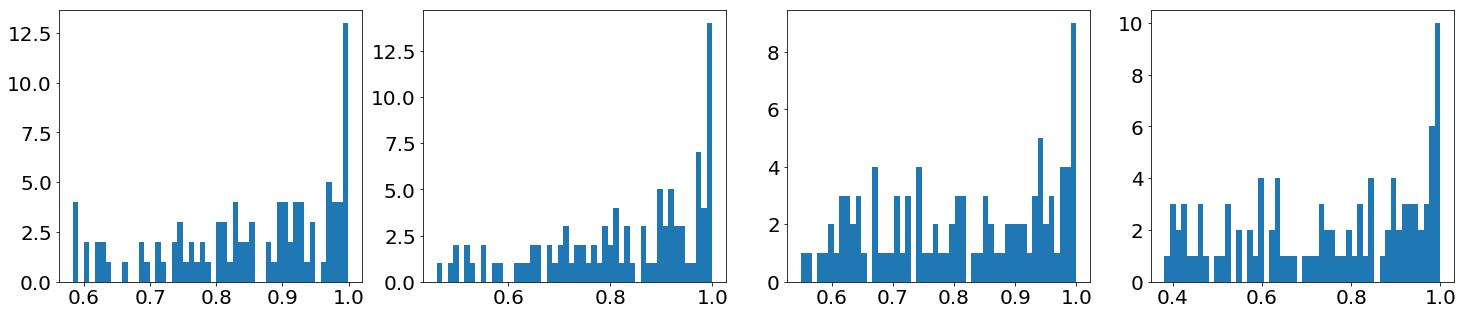

In [157]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

_= axes[0].hist(np.max(input_vae_old[0], axis = (1,2,3)), bins = 50)
_= axes[1].hist(np.max(input_vae_old[1], axis = (1,2,3)), bins = 50)
_= axes[2].hist(np.max(input_vae_new[0], axis = (1,2,3)), bins = 50)
_= axes[3].hist(np.max(input_vae_new[1], axis = (1,2,3)), bins = 50)

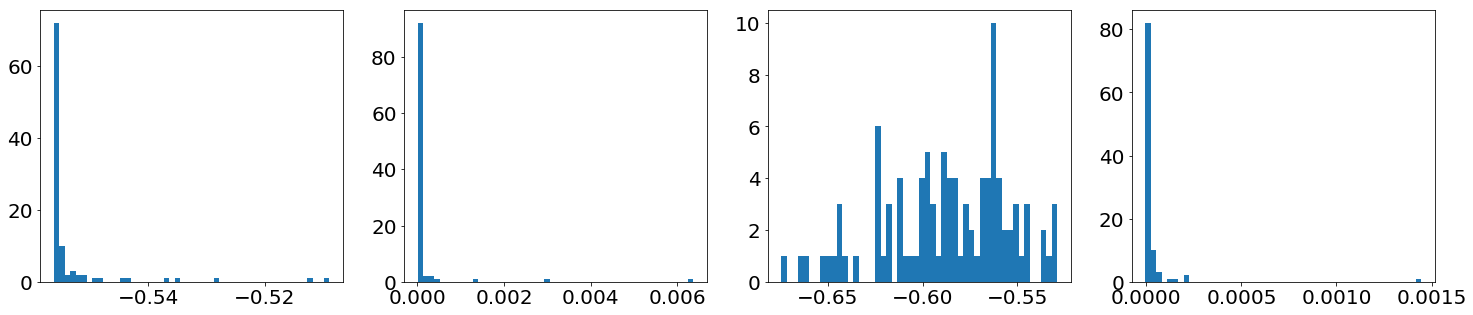

In [158]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))

_= axes[0].hist(np.min(input_vae_old[0], axis = (1,2,3)), bins = 50)
_= axes[1].hist(np.min(input_vae_old[1], axis = (1,2,3)), bins = 50)
_= axes[2].hist(np.min(input_vae_new[0], axis = (1,2,3)), bins = 50)
_= axes[3].hist(np.min(input_vae_new[1], axis = (1,2,3)), bins = 50)

[[0.51236289]
 [0.86002383]
 [0.548557  ]
 [0.83290803]
 [0.76607452]
 [0.90583826]
 [0.81042855]
 [0.99856646]
 [0.5066371 ]
 [0.73991539]
 [0.76644131]
 [0.50039499]
 [0.58597902]
 [0.66007342]
 [0.79334137]
 [0.59290305]
 [0.77658641]
 [0.5900035 ]
 [0.67043052]
 [0.83196703]
 [0.67099472]
 [0.85891566]
 [0.68149611]
 [0.59685261]
 [0.64565411]
 [0.69366822]
 [0.48675258]
 [0.88911692]
 [0.53208348]
 [0.95565517]
 [0.63500343]
 [0.75294965]
 [0.84619779]
 [0.67877245]
 [0.9930929 ]
 [0.88503732]
 [0.77710425]
 [0.60216928]
 [0.87030388]
 [0.66730651]
 [0.79177374]
 [0.69827555]
 [0.89082144]
 [0.85299214]
 [0.58228237]
 [0.74428736]
 [0.50707995]
 [0.99865866]
 [0.98268238]
 [0.69674931]
 [0.48072745]
 [0.88510704]
 [0.9681684 ]
 [0.43257618]
 [0.73609181]
 [0.44013016]
 [0.47227123]
 [0.69469951]
 [0.45398394]
 [0.98542775]
 [0.98293042]
 [0.69928777]
 [0.53916068]
 [0.66673469]
 [0.85259825]
 [0.80213103]
 [0.7250897 ]
 [0.57742216]
 [0.68392344]
 [0.76385803]
 [0.7599131 ]
 [0.87

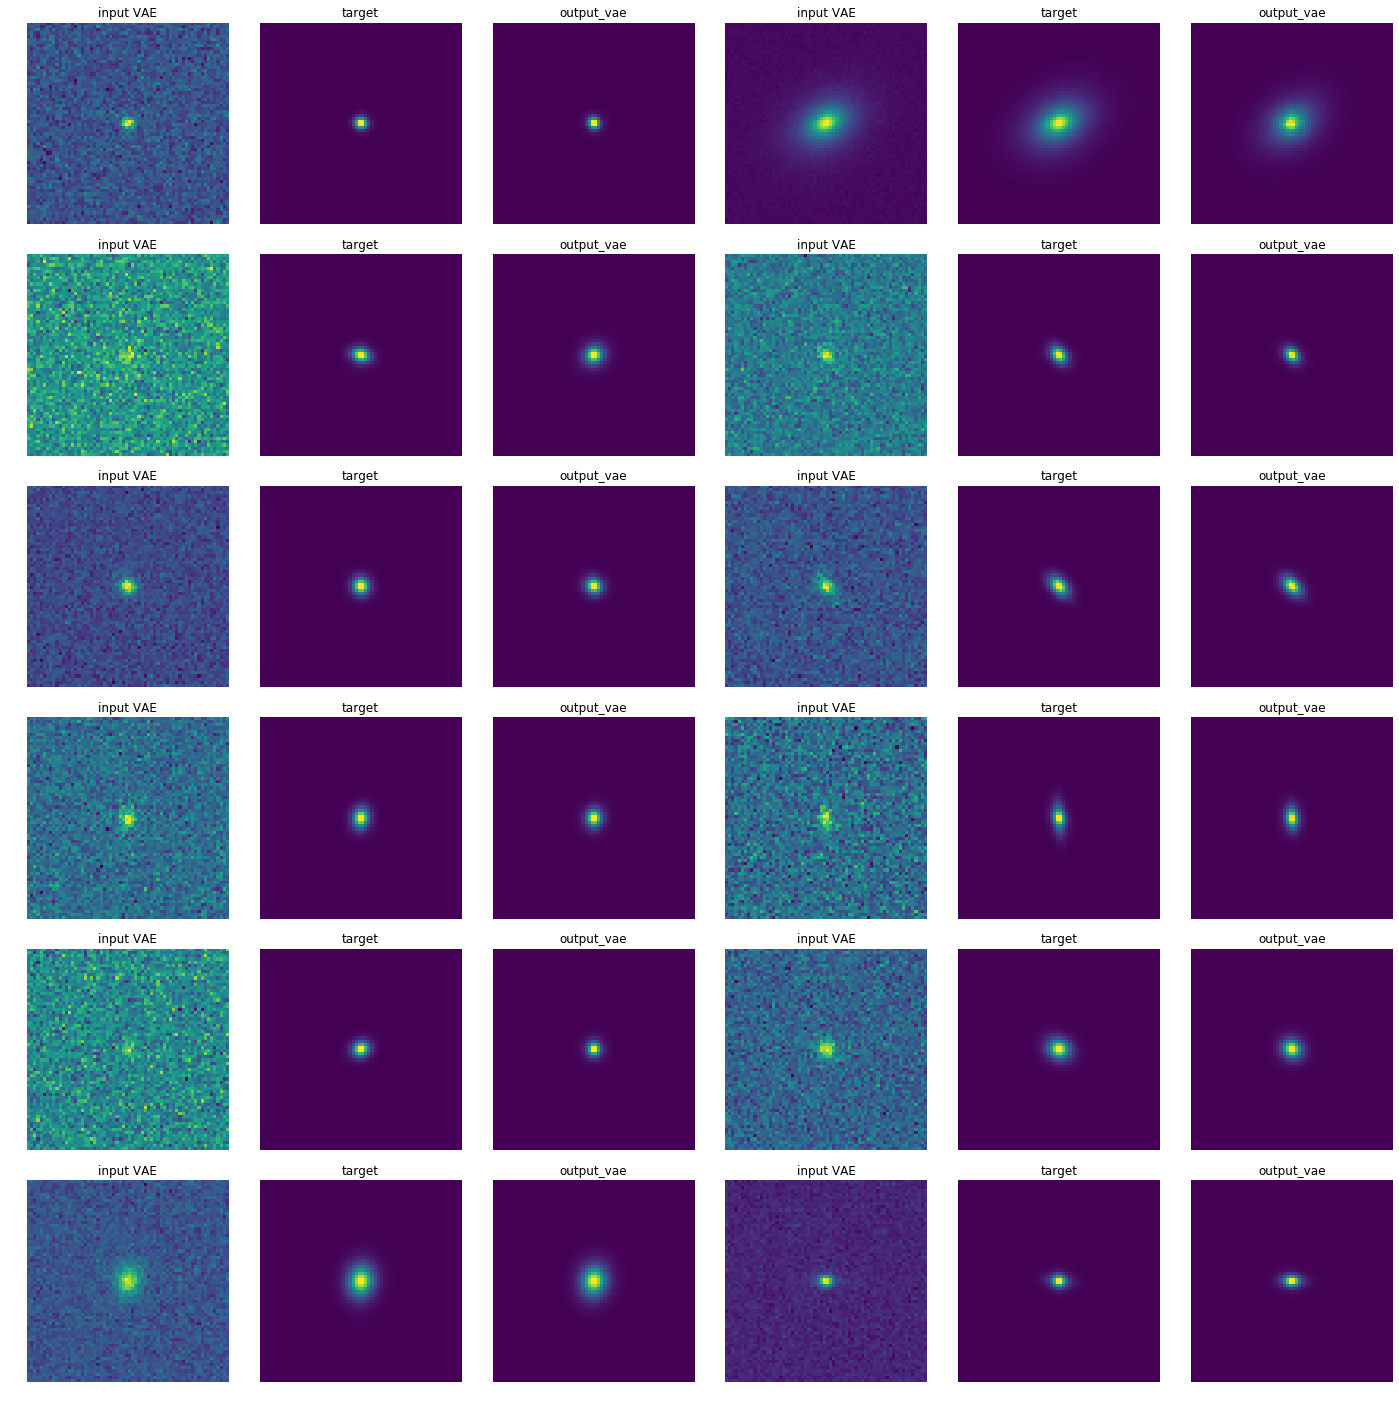

In [30]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae_old = batch_gen_old.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae_old[0], batch_size = 100)
print(np.max(input_vae_old[0], axis = (1,2)))

input_noisy = denorm(input_vae_old[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae_old[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('target')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('output_vae')

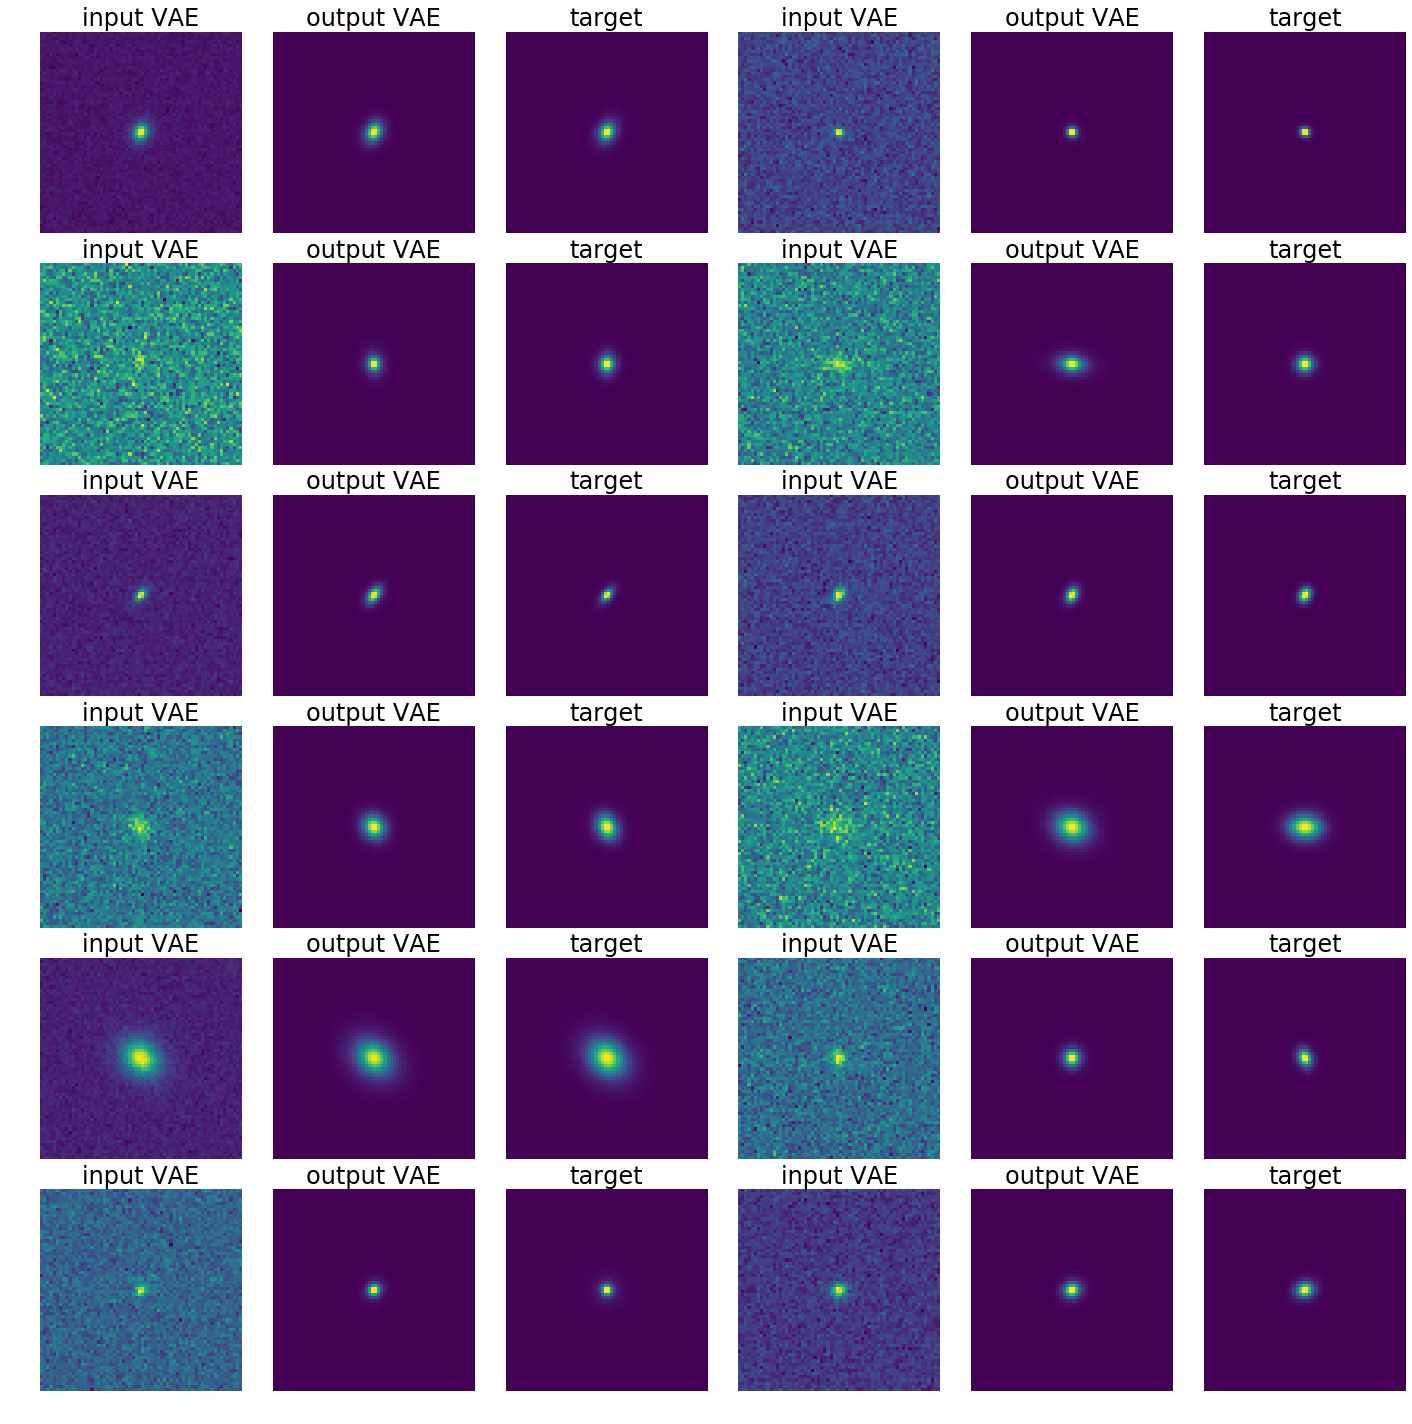

In [90]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_new.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


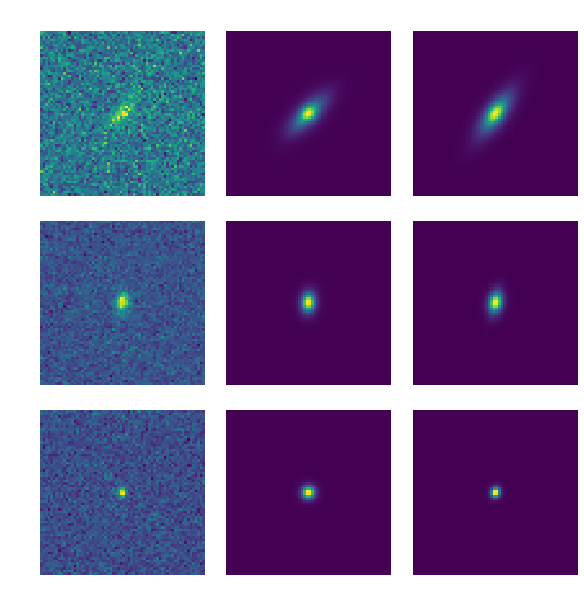

In [19]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(3, N_plot, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_new.__getitem__(2)
output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)
#print(np.max(output_vae, axis = (1,2)))
input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
output_vae = denorm(output_vae, bands_r, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]].reshape((64,64)))
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]].reshape((64,64)))
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST all filters

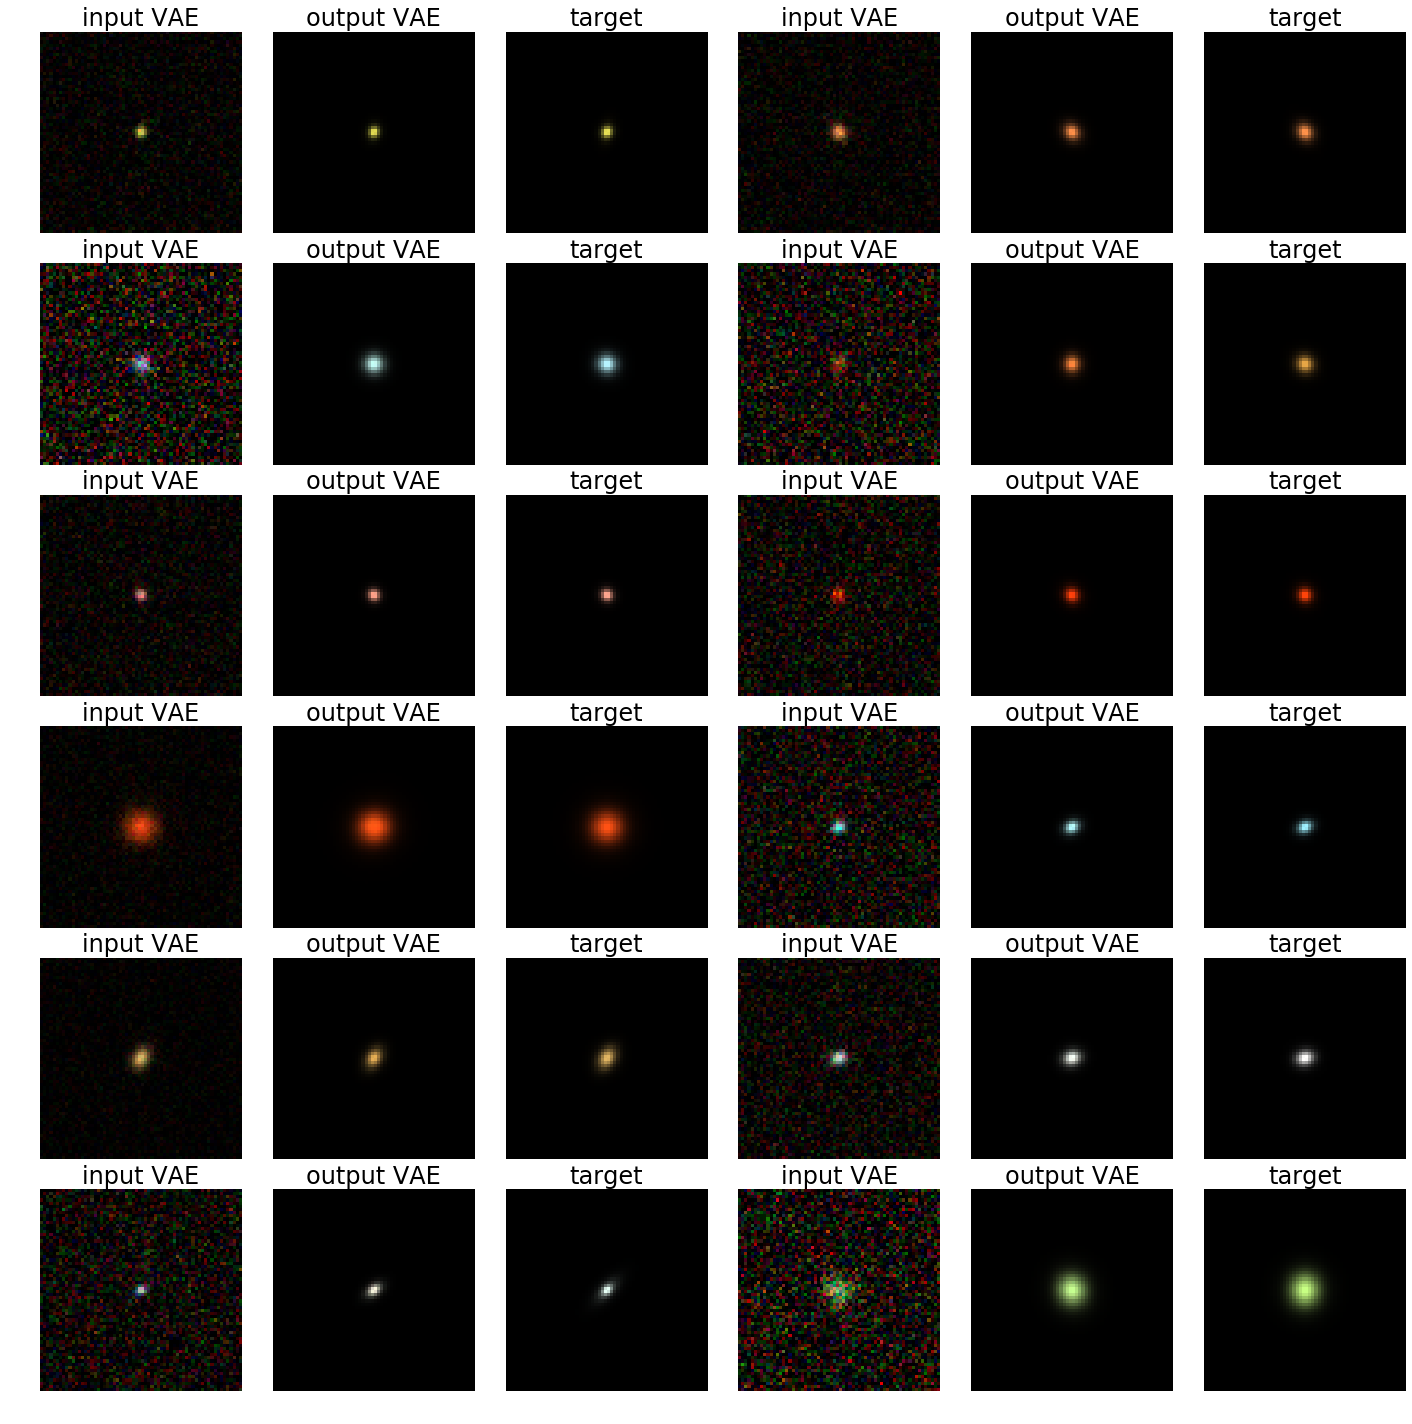

In [27]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

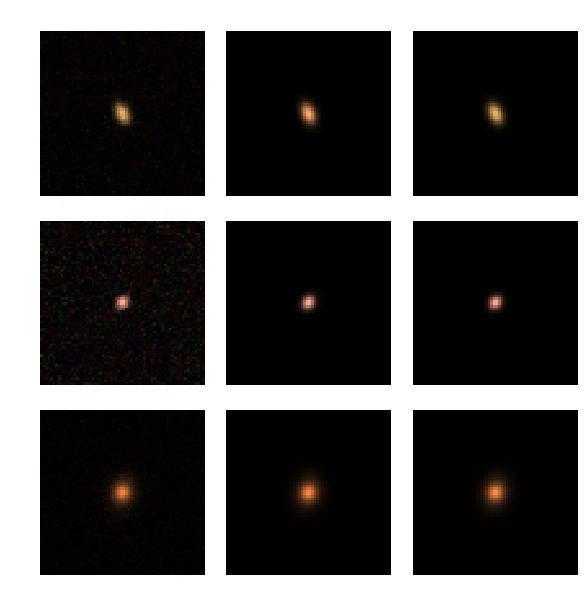

In [28]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst.__getitem__(2)
output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)

input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
output_vae = denorm(output_vae, bands_lsst, channel_last = True)

for i in range(3):
    for j in range(0,N_plot,3):
        
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST+Euclid filters

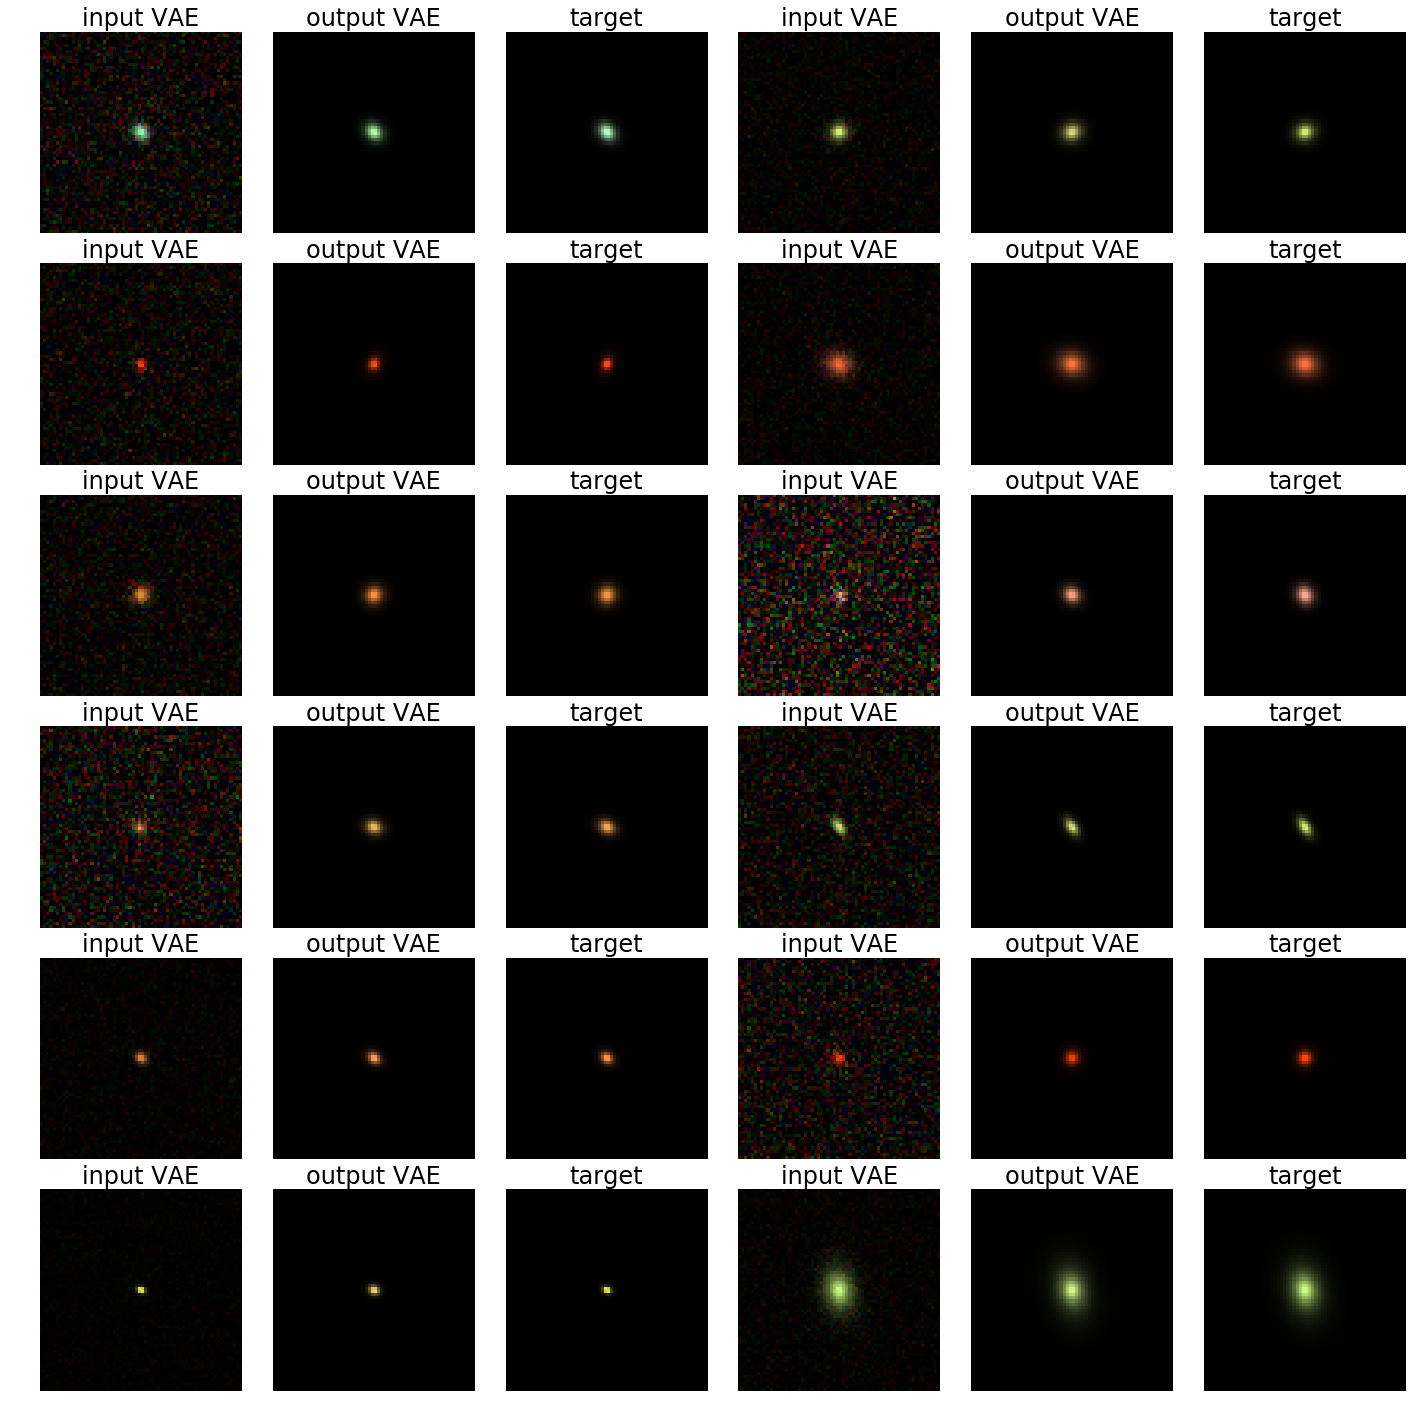

In [31]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_vae = batch_gen_lsst_euclid.__getitem__(2)
output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = 100)


#input_noisy = input_vae[0]
#input_noiseless = input_vae[1]
input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
output_vae = denorm(output_vae, bands_lsst_euclid, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):

        plot_rgb_lsst_euclid(input_noisy[indices[i*N_plot+j]], stamp_size, axes[i,j])
        plot_rgb_lsst_euclid(output_vae[indices[i*N_plot+j]], stamp_size, axes[i,j+1])
        plot_rgb_lsst_euclid(input_noiseless[indices[i*N_plot+j]], stamp_size, axes[i,j+2])

        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

## VAE LSST R band

In [45]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_R=[]
e=[]

N = 100

lum_in_simple_r = np.empty([N,N,],dtype='float32')
lum_out_simple_r= np.empty([N,N,], dtype='float32')

for j in range(N):
    input_vae = batch_gen_new.__getitem__(2)
    output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_r, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_r, channel_last = True)
    output_vae = denorm (output_vae, bands_r, channel_last = True)
    
    for i in range (len(input_vae[0])):
        try: 
            gal_image = galsim.Image(input_noiseless[i].reshape((64,64)))
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i].reshape((64,64)))
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])

            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i].reshape((64,64)).copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i].reshape((64,64)).copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple_r[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple_r[j,i] = np.sum(masked_img_out_simple)
          
        except :
            print('erreur')
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
e_beta = np.array(e)

erreur
erreur
erreur
erreur


In [128]:
ellipticities_r_band[:,0,1].shape

(10000,)

### Shape plots

alpha 10-3

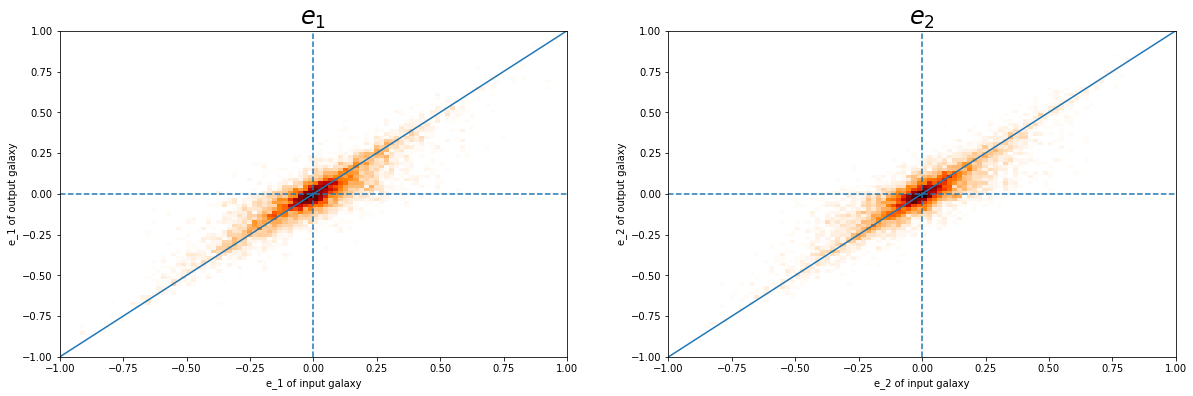

In [46]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

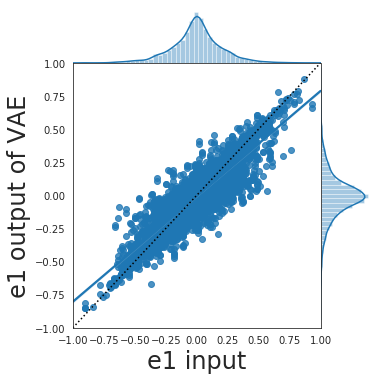

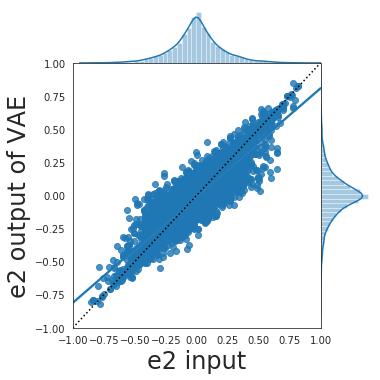

In [47]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

1 700 000 galaxies as training sample

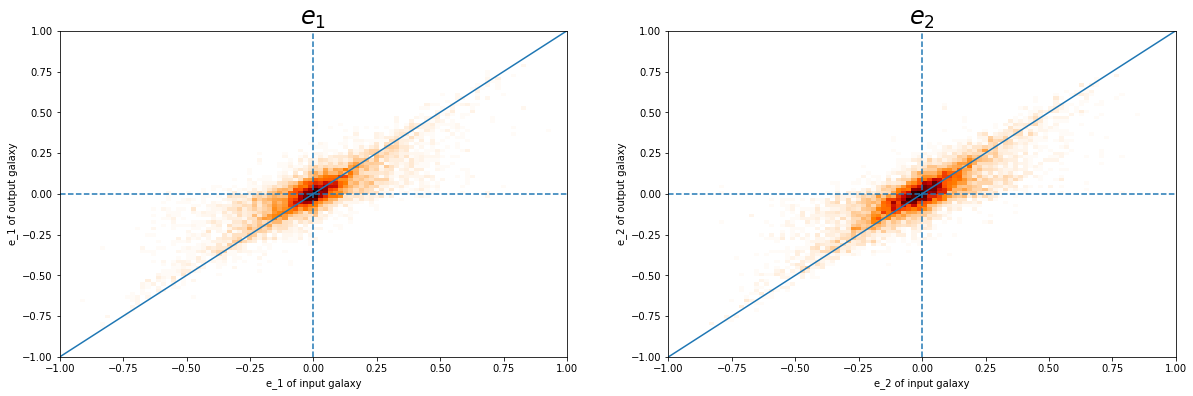

In [20]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

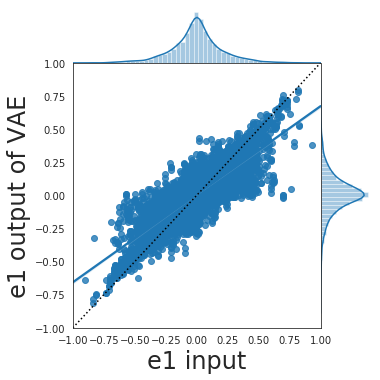

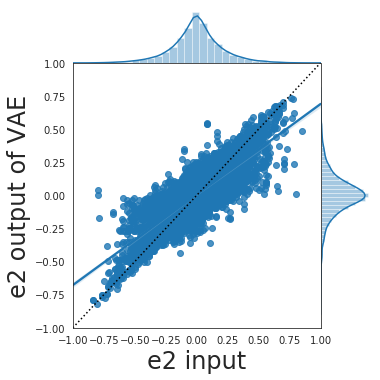

In [21]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Alpha from 10-4 to 10-6

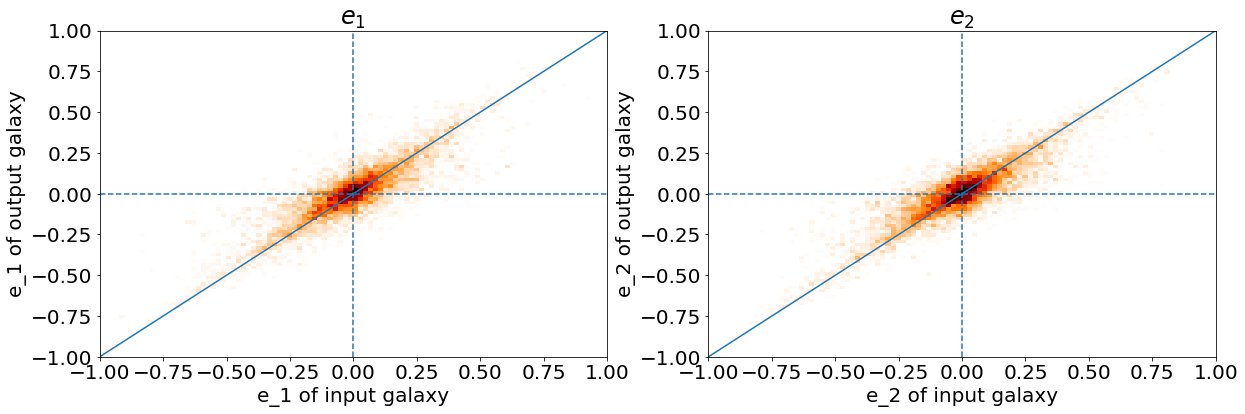

In [35]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

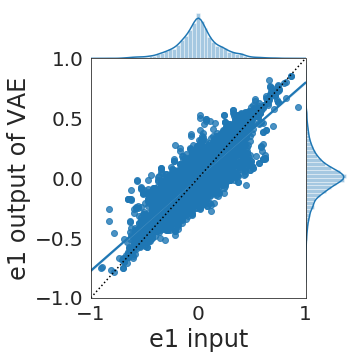

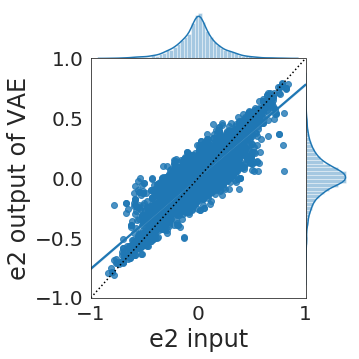

In [36]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Alpha 10-4

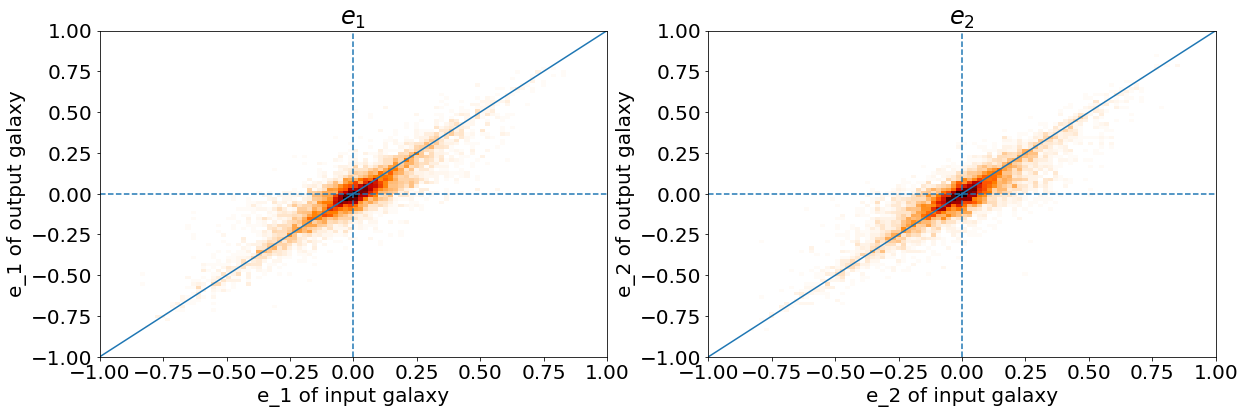

In [66]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

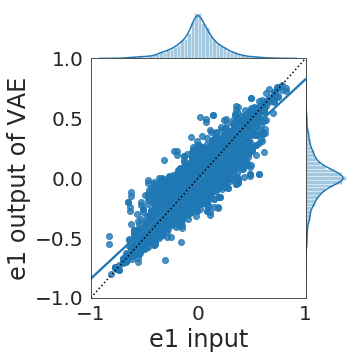

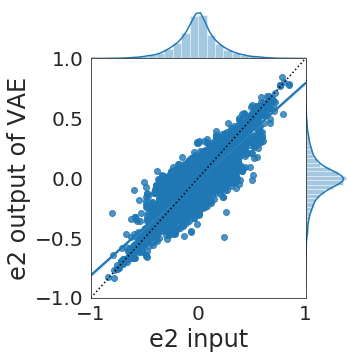

In [67]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Alpha 10-2

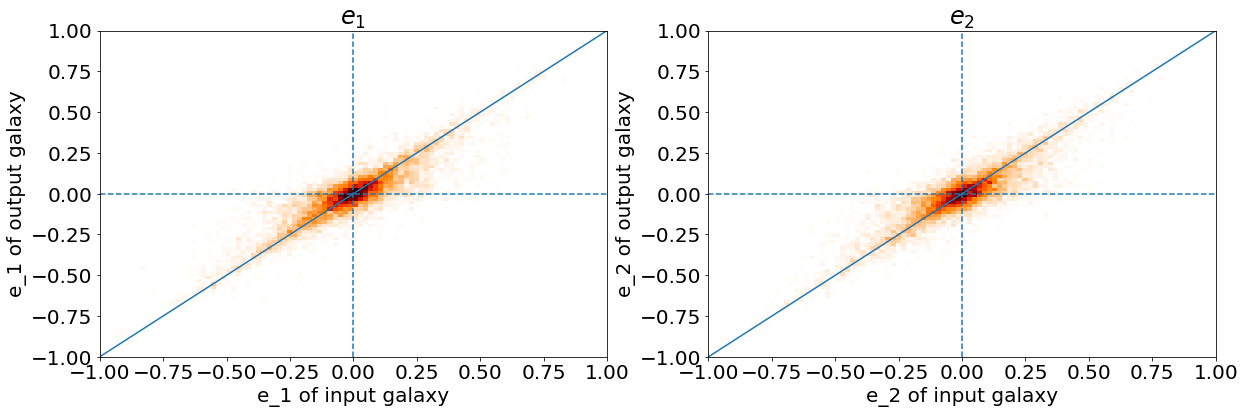

In [92]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

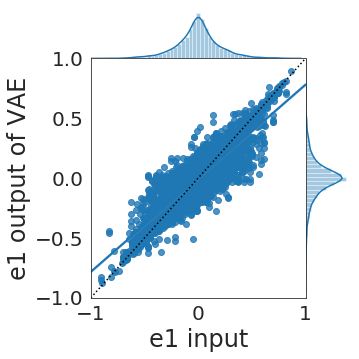

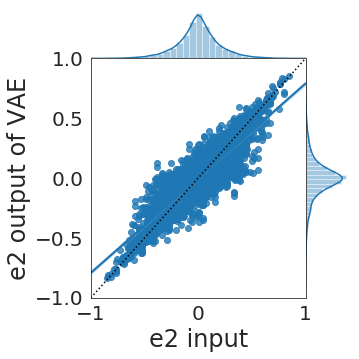

In [93]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Alpha 10-1

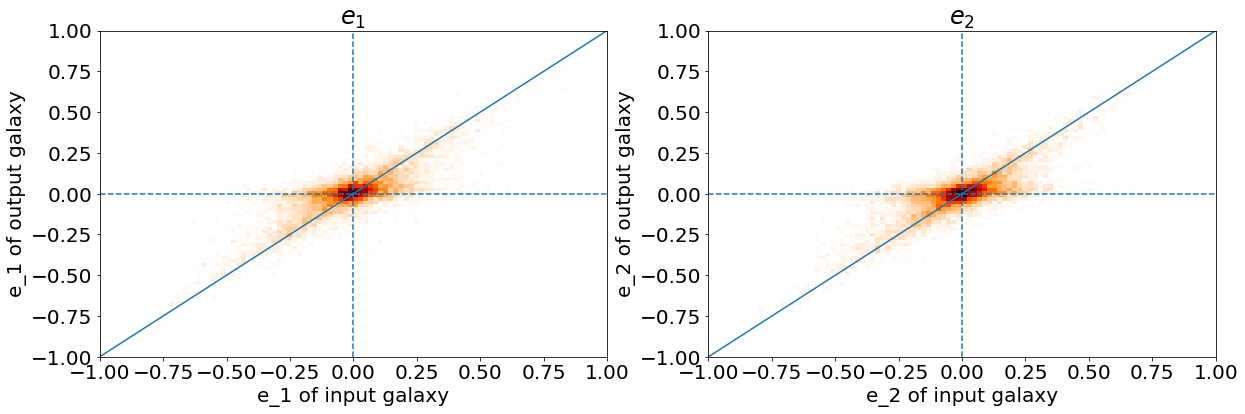

In [106]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

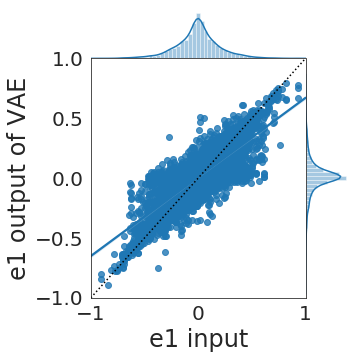

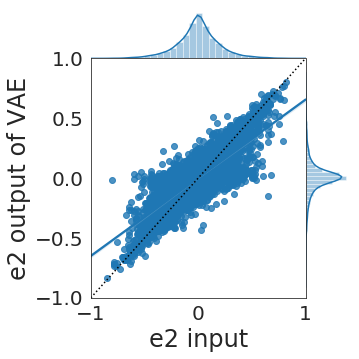

In [107]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

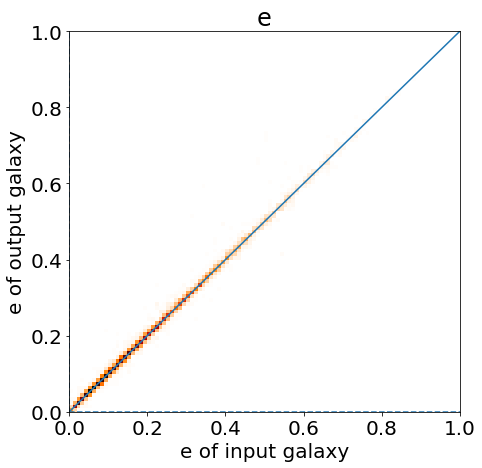

In [130]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

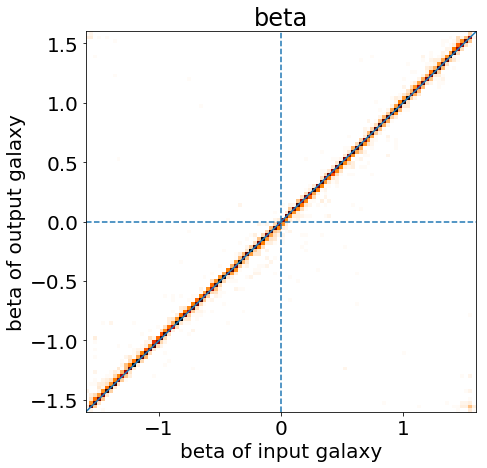

In [131]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plots

In [110]:
lum_in_simple_r = np.concatenate(lum_in_simple_r)
lum_out_simple_r = np.concatenate(lum_out_simple_r)

Alpha from 10-4 to 10-6

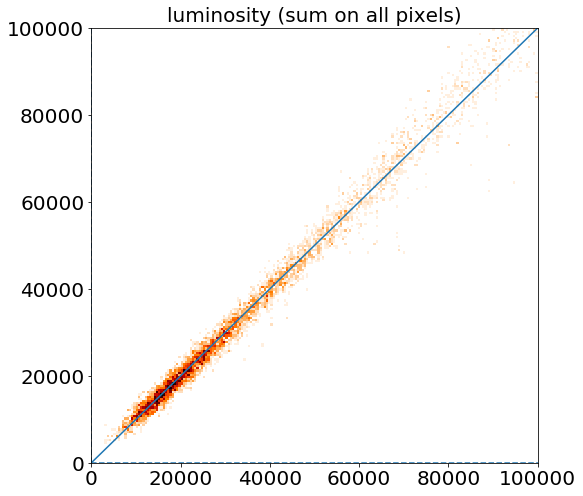

In [38]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_r, lum_out_simple_r, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

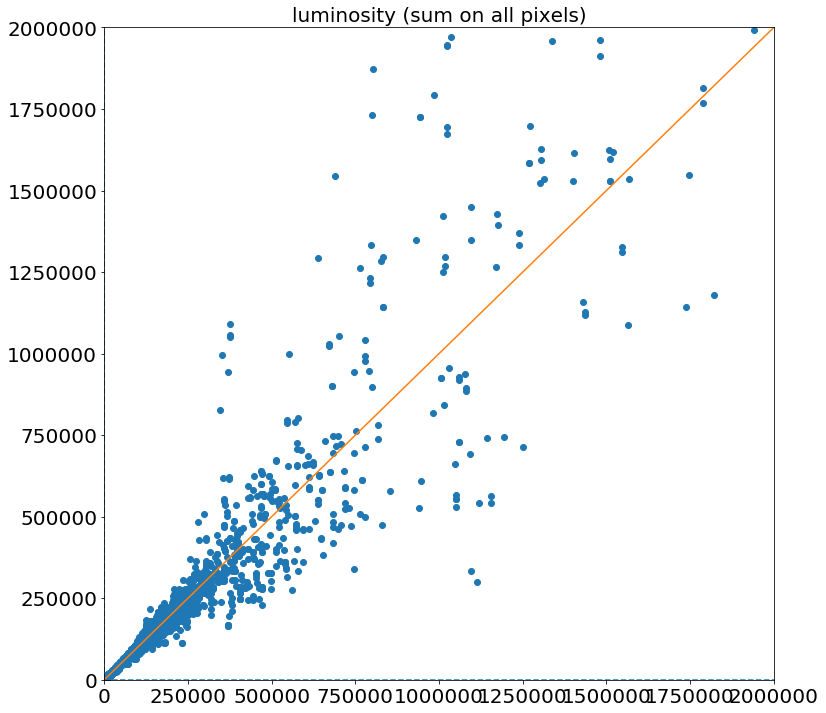

In [39]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

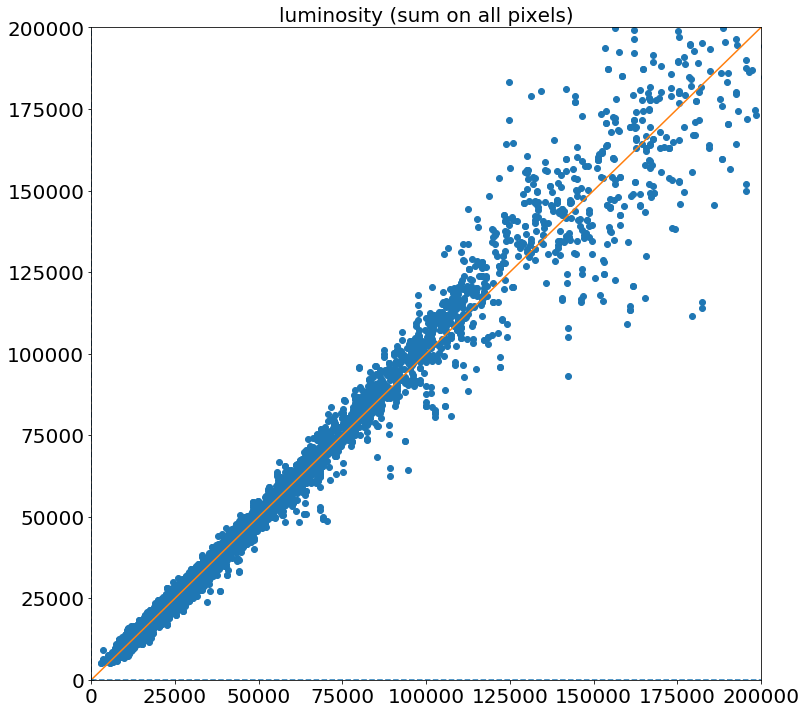

In [40]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

Alpha 10-4

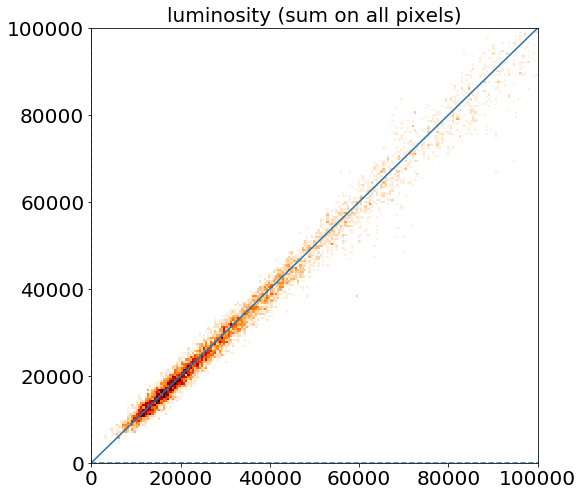

In [70]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_r, lum_out_simple_r, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

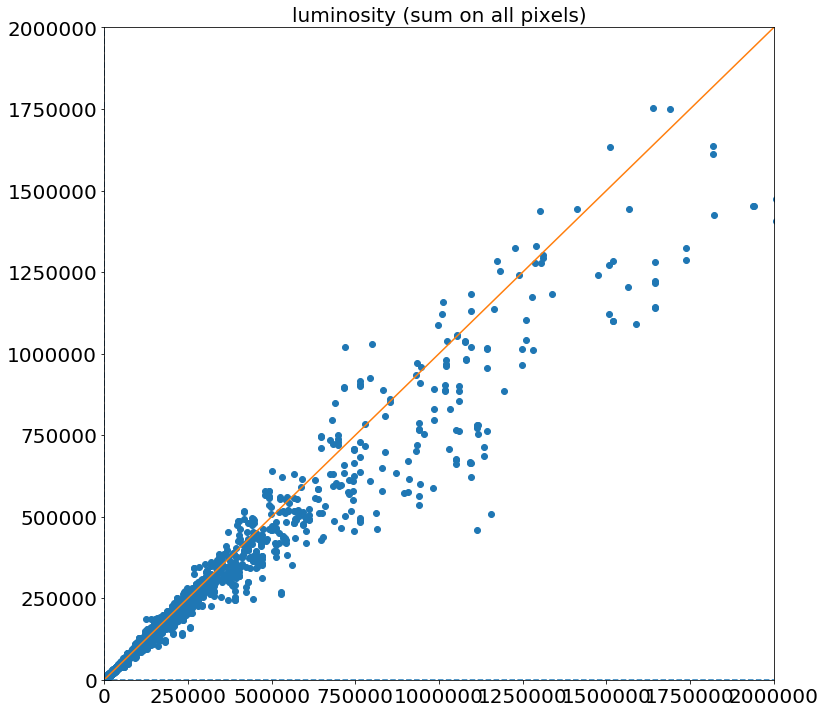

In [71]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

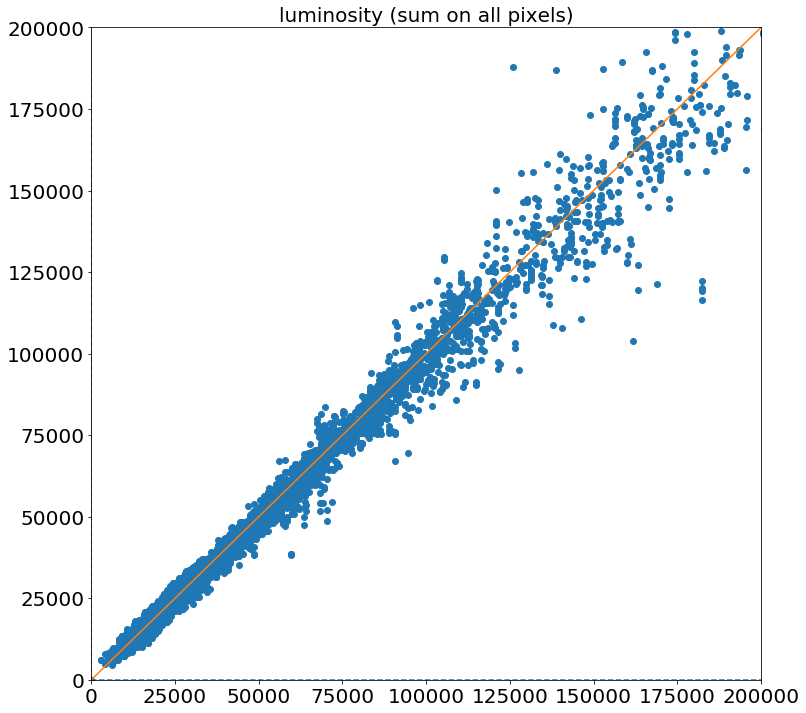

In [72]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

Alpha 10-2

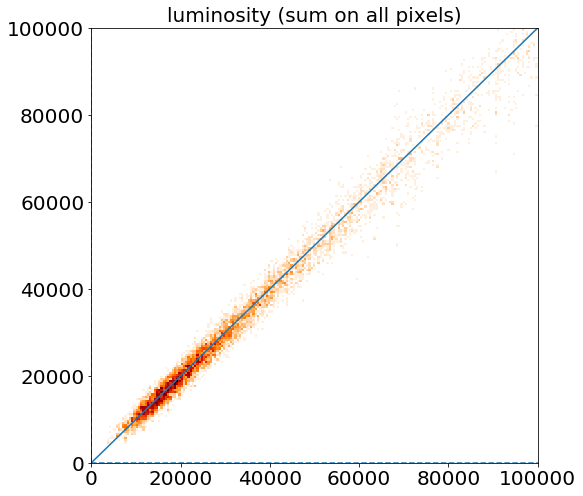

In [95]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_r, lum_out_simple_r, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

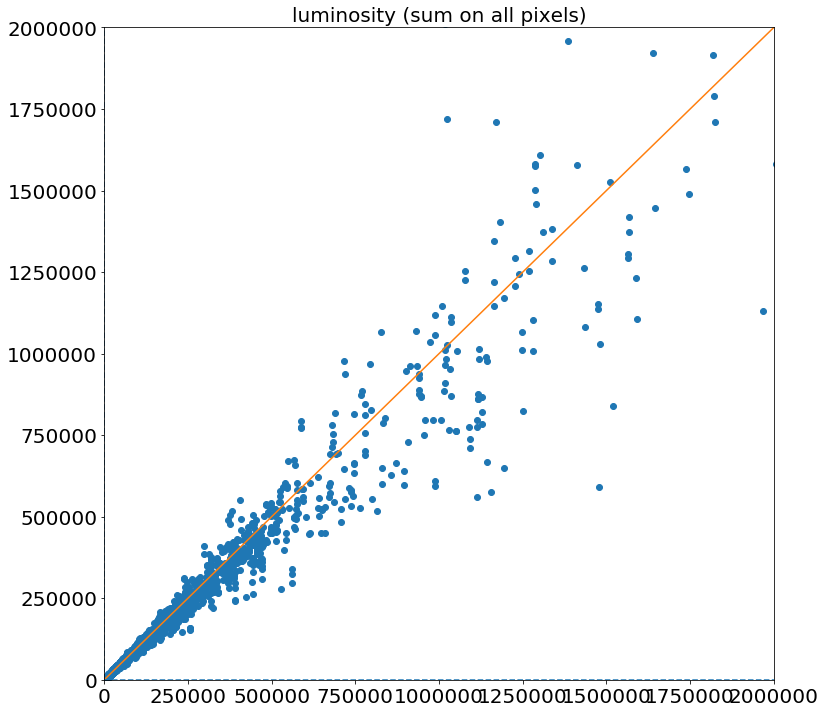

In [96]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

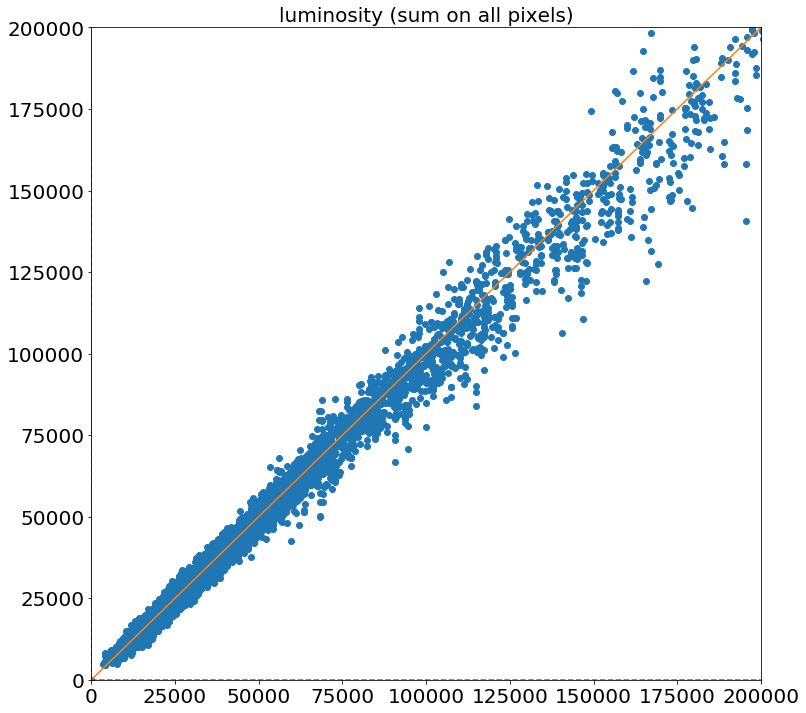

In [97]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

Alpha 10-1

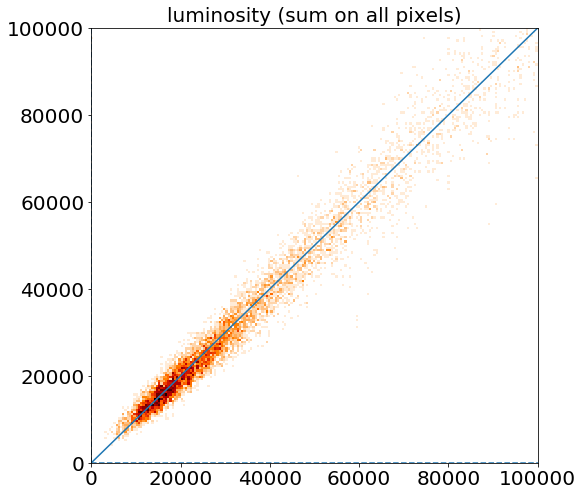

In [111]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_r, lum_out_simple_r, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

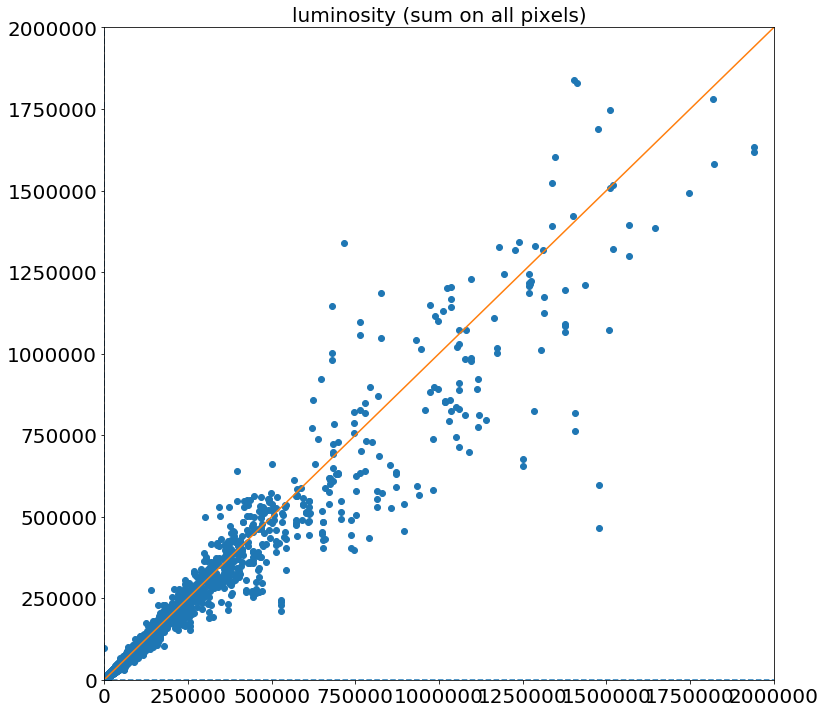

In [112]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

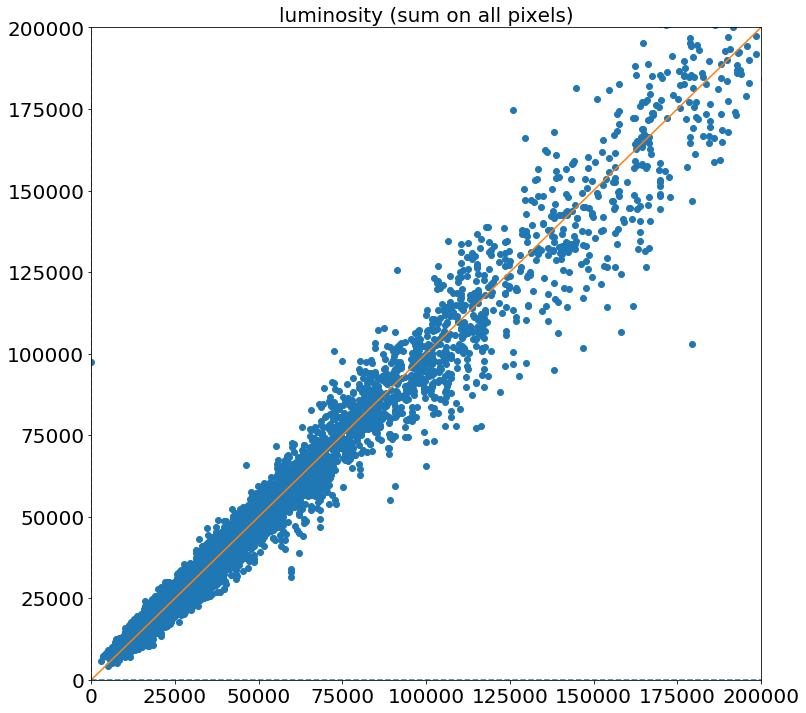

In [113]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_r, lum_out_simple_r,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Delta_e1 / Delta_e2

In [143]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

(-0.4, 0.4)

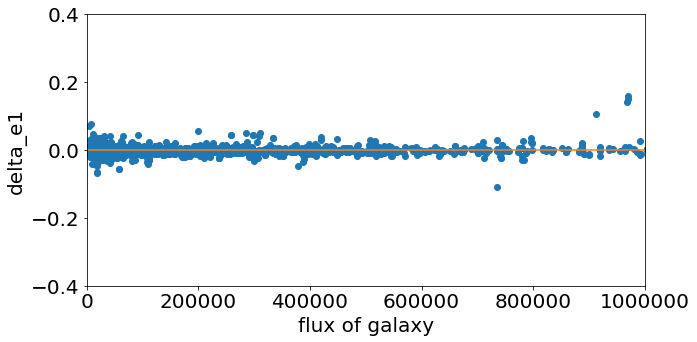

In [144]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple[:len(delta_e1)], delta_e1, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e1')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

(-0.4, 0.4)

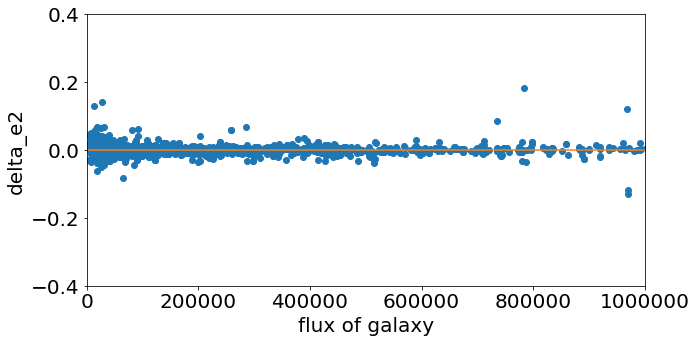

In [145]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple[:len(delta_e2)], delta_e2, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e2')
plt.plot([0,1000000],[0,0])
plt.ylim(-0.4,0.4)

### Corner plot latent space

In [41]:
batch_size = 100

In [44]:
a = batch_gen_new.__getitem__(2)
output_enc = encoder_R.predict(a[0], batch_size = batch_size)

In [45]:
latent_dim =32
epsilon_std = 1.0

In [46]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [47]:
z = []
for i in range (100):
    a = batch_gen_new.__getitem__(2)
    output_enc = encoder_R.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


In [48]:
z = np.concatenate(z, axis = 0)

In [49]:
len(z)

10000

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


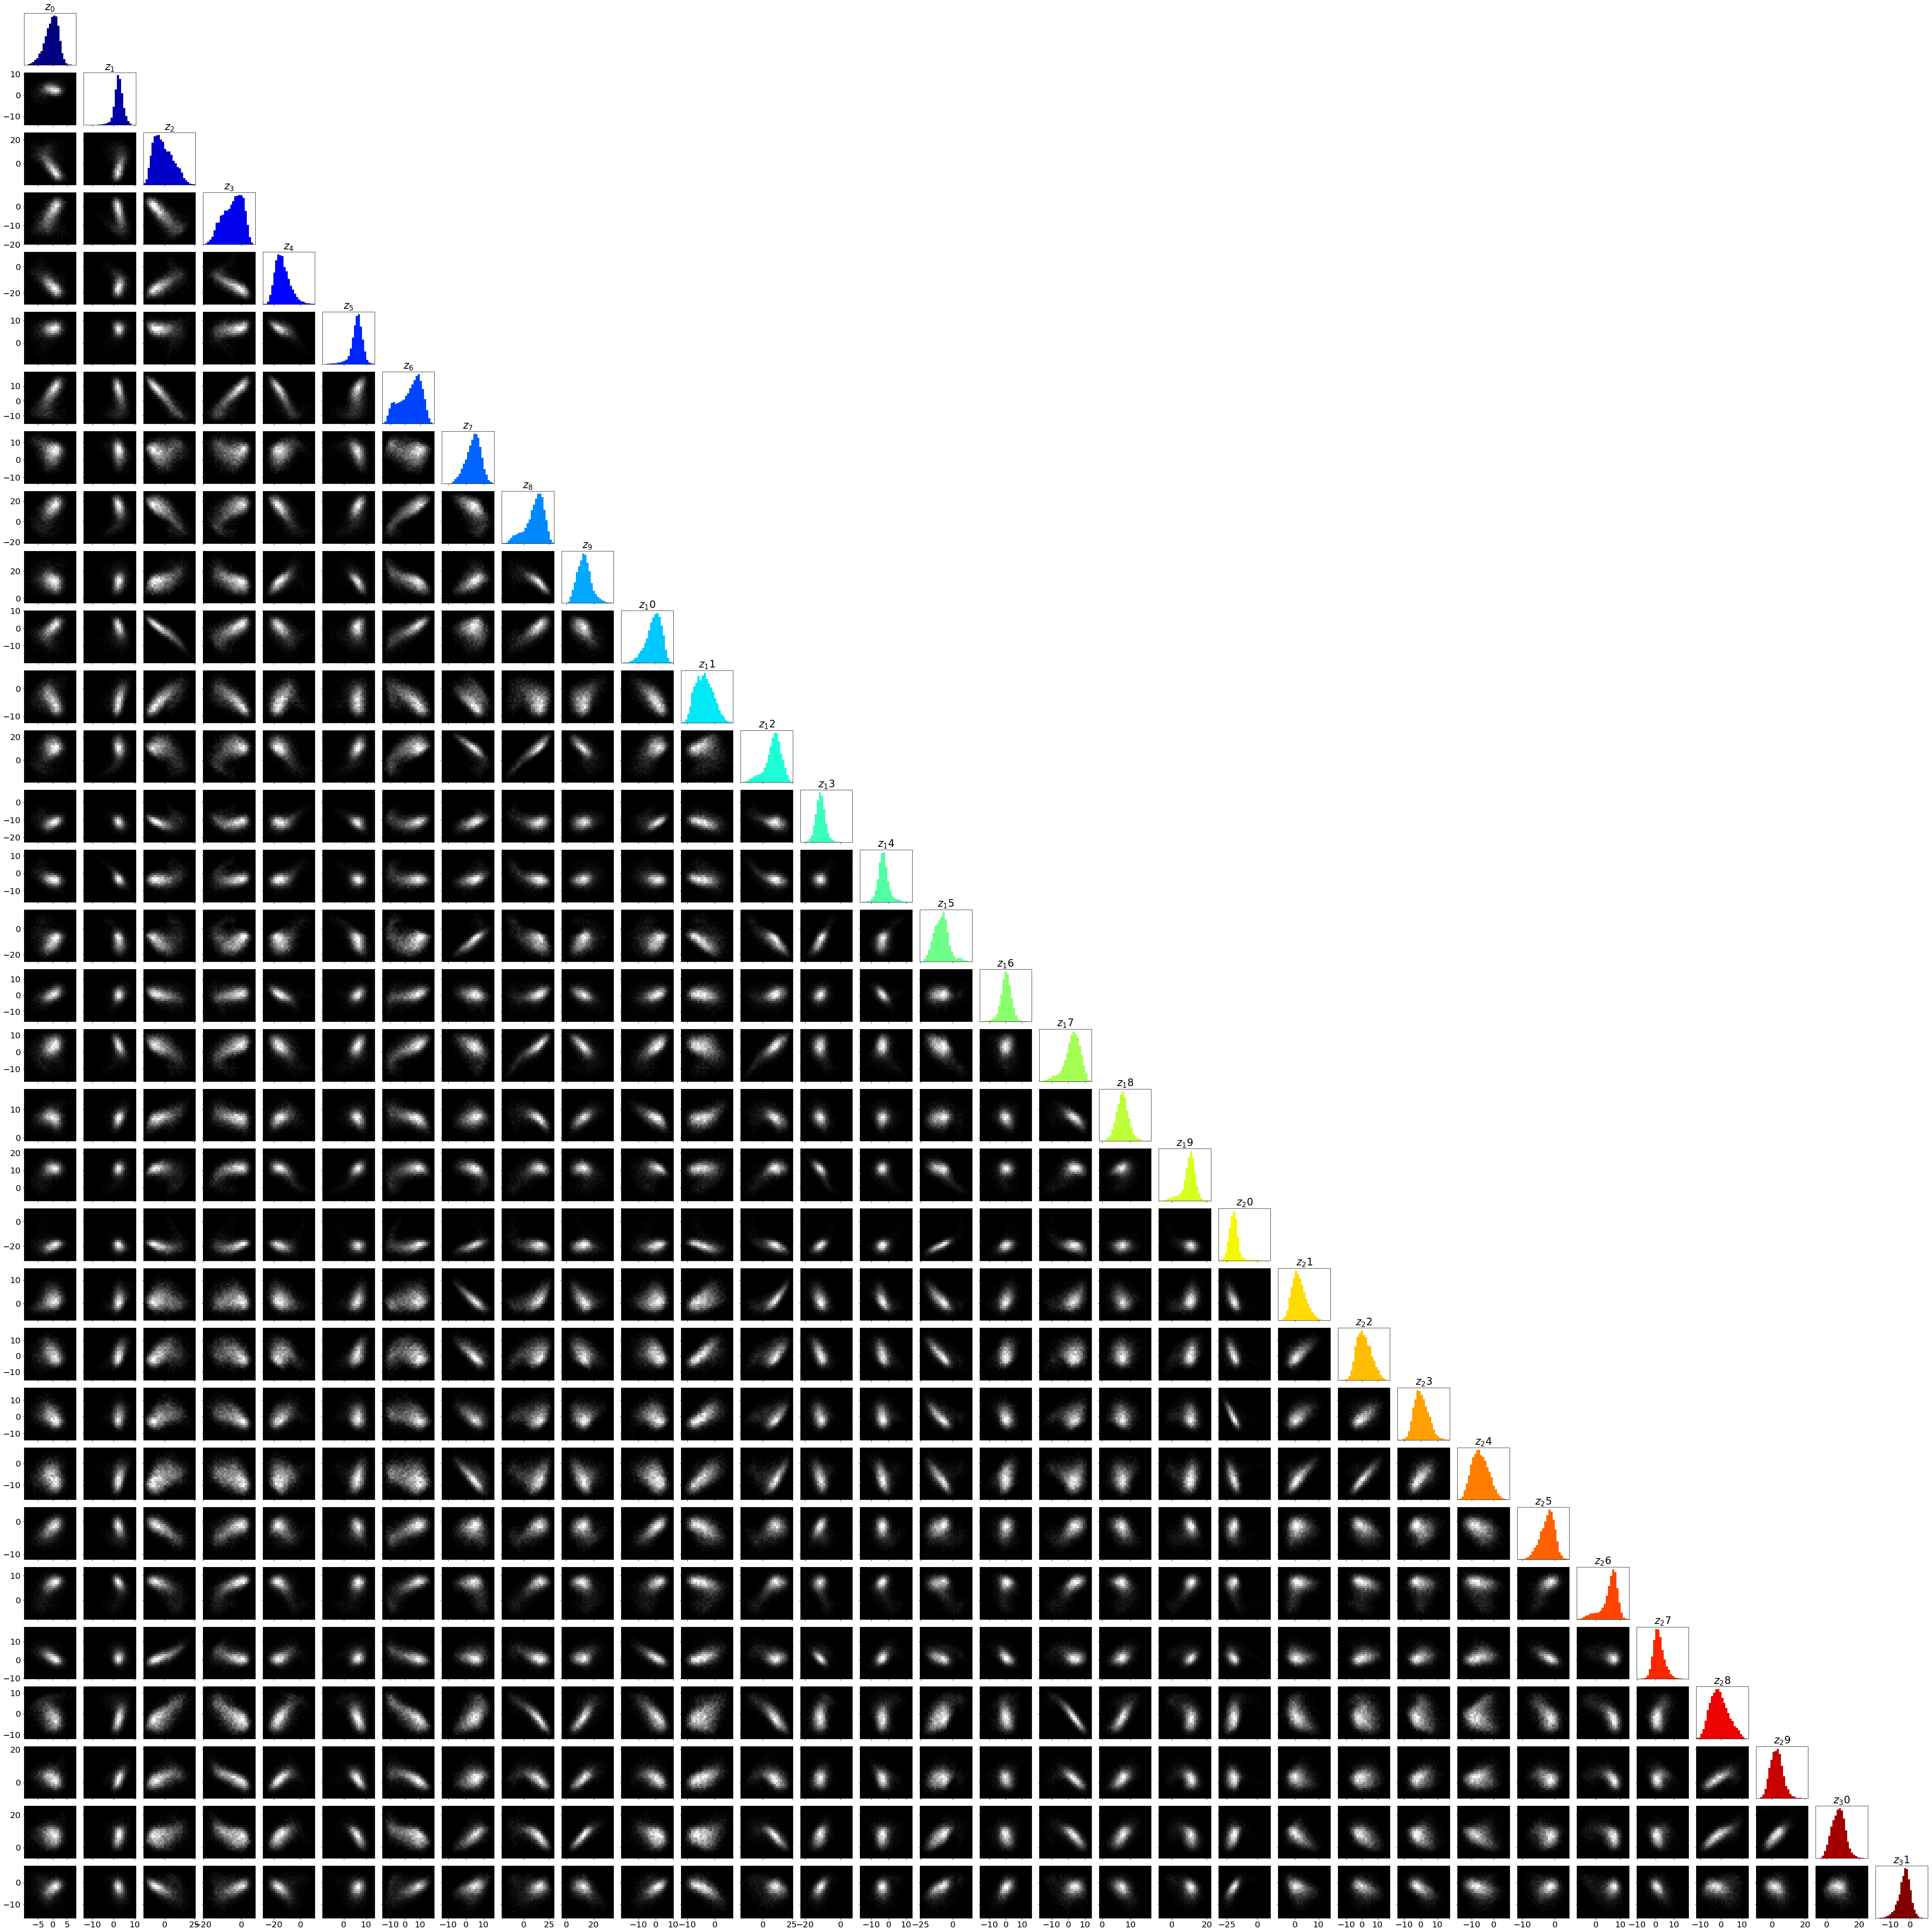

In [50]:
plot_corner_latent(z)

## LSST all filters

In [22]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]

ellipticities = []
e=[]
counts = 0

N = 100

lum_in_simple_lsst = np.empty([N,N,],dtype='float32')
lum_out_simple_lsst= np.empty([N,N,], dtype='float32')


for j in range(N):
    input_vae = batch_gen_lsst.__getitem__(2)
    output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_lsst, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_lsst, channel_last = True)
    output_vae = denorm (output_vae, bands_lsst, channel_last = True)
    
    for i in range (len(input_vae[0])):
        try:
            gal_image = galsim.Image(input_noiseless[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])
            
            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,2].reshape((64,64)).copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,2].reshape((64,64)).copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple_lsst[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple_lsst[j,i] = np.sum(masked_img_out_simple)


        except :
            print('erreur')
            counts+=1
            pass
        continue

ellipticities_LSST = np.array(ellipticities)
e_beta = np.array(e)
print('number of errors: '+str(counts))

erreur
erreur
erreur
number of errors: 3


### Shape plots

Alpha 10-2

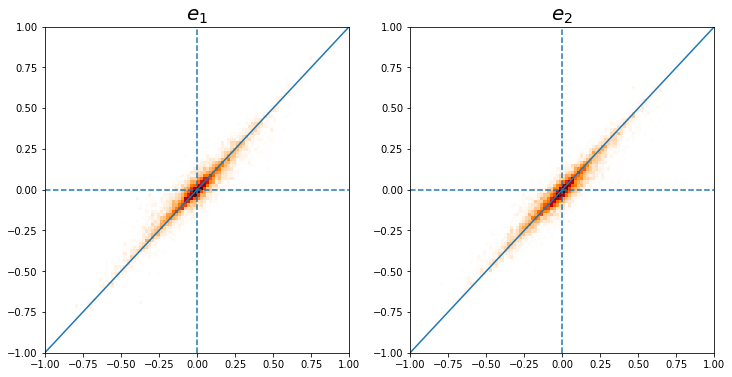

In [23]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST[:,0,i], ellipticities_LSST[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')

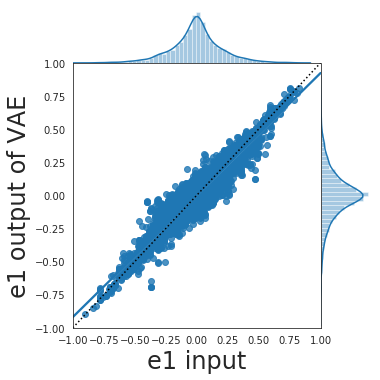

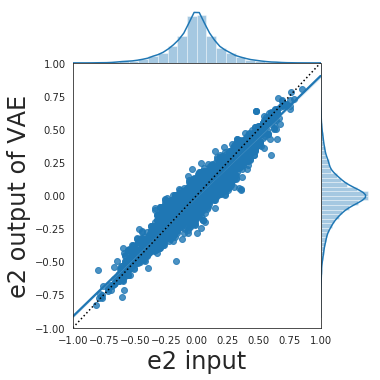

In [24]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST[:,0,0], ellipticities_LSST[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST[:,0,1], ellipticities_LSST[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

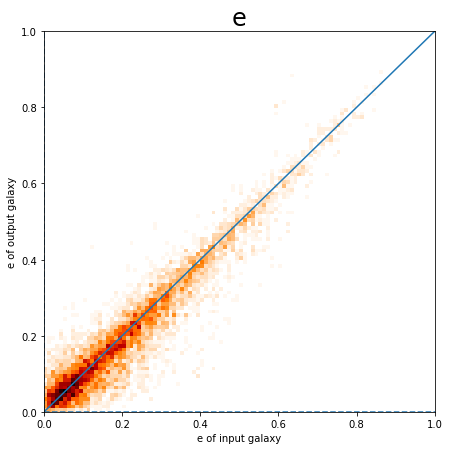

In [25]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

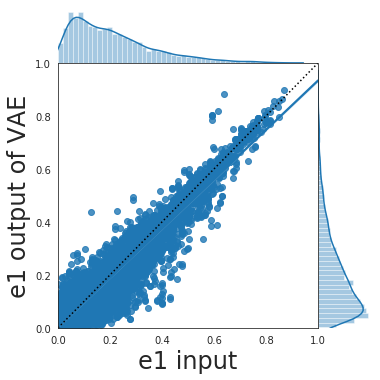

In [28]:
with sns.axes_style('white'):
            g = sns.jointplot(e_beta[:,0,0], e_beta[:,1,0], kind='reg',height =5,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


Text(0, 0.5, 'beta of output galaxy')

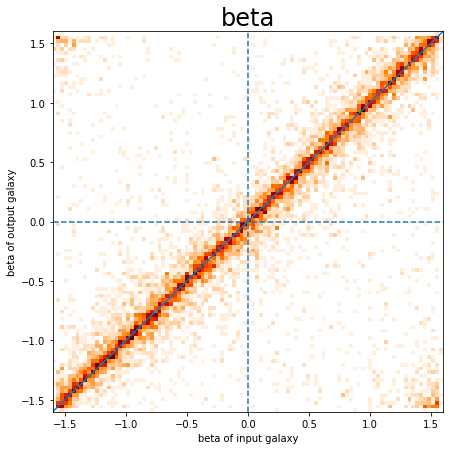

In [29]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plot

In [30]:
lum_in_simple_lsst = np.concatenate(lum_in_simple_lsst)
lum_out_simple_lsst = np.concatenate(lum_out_simple_lsst)

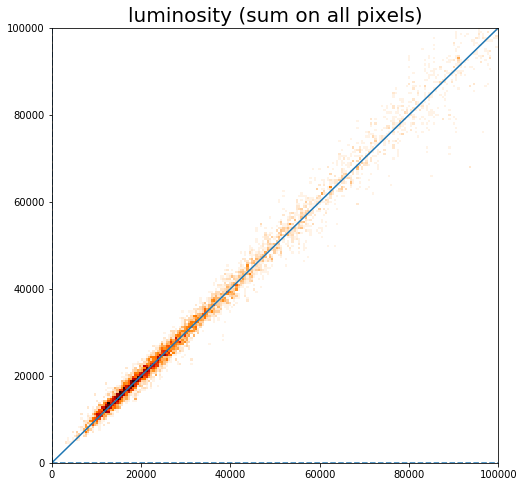

In [31]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_lsst, lum_out_simple_lsst, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

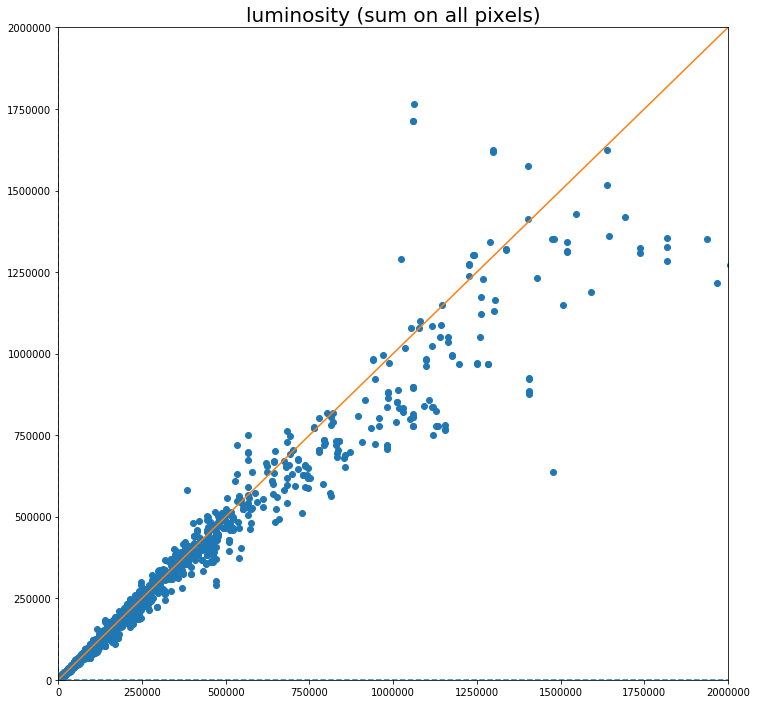

In [32]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_lsst, lum_out_simple_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

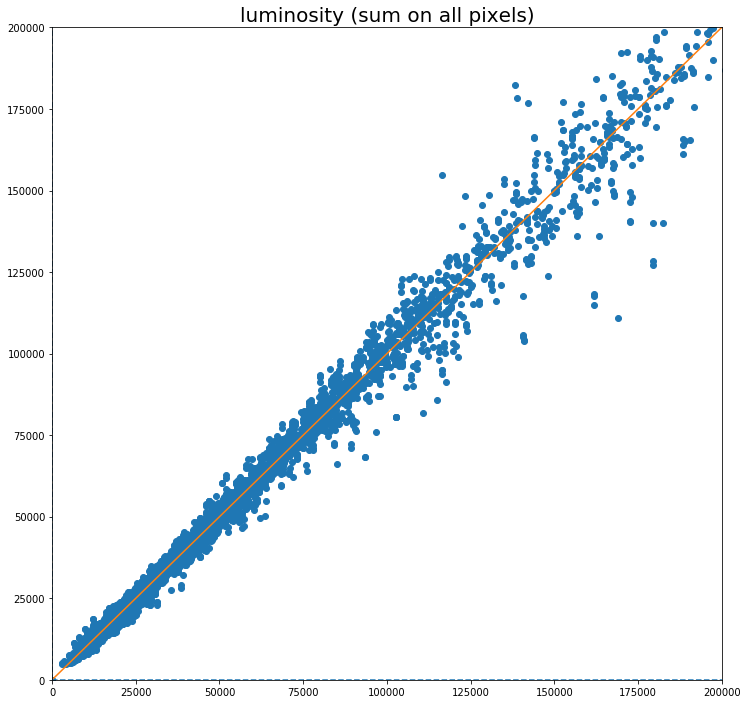

In [33]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_lsst, lum_out_simple_lsst,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Corner plot latent space

In [42]:
batch_size = 100
a = batch_gen_lsst.__getitem__(2)
output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
latent_dim =32
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

z = []

In [43]:
for i in range (100):
    a = batch_gen_lsst.__getitem__(2)
    output_enc = encoder_LSST.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


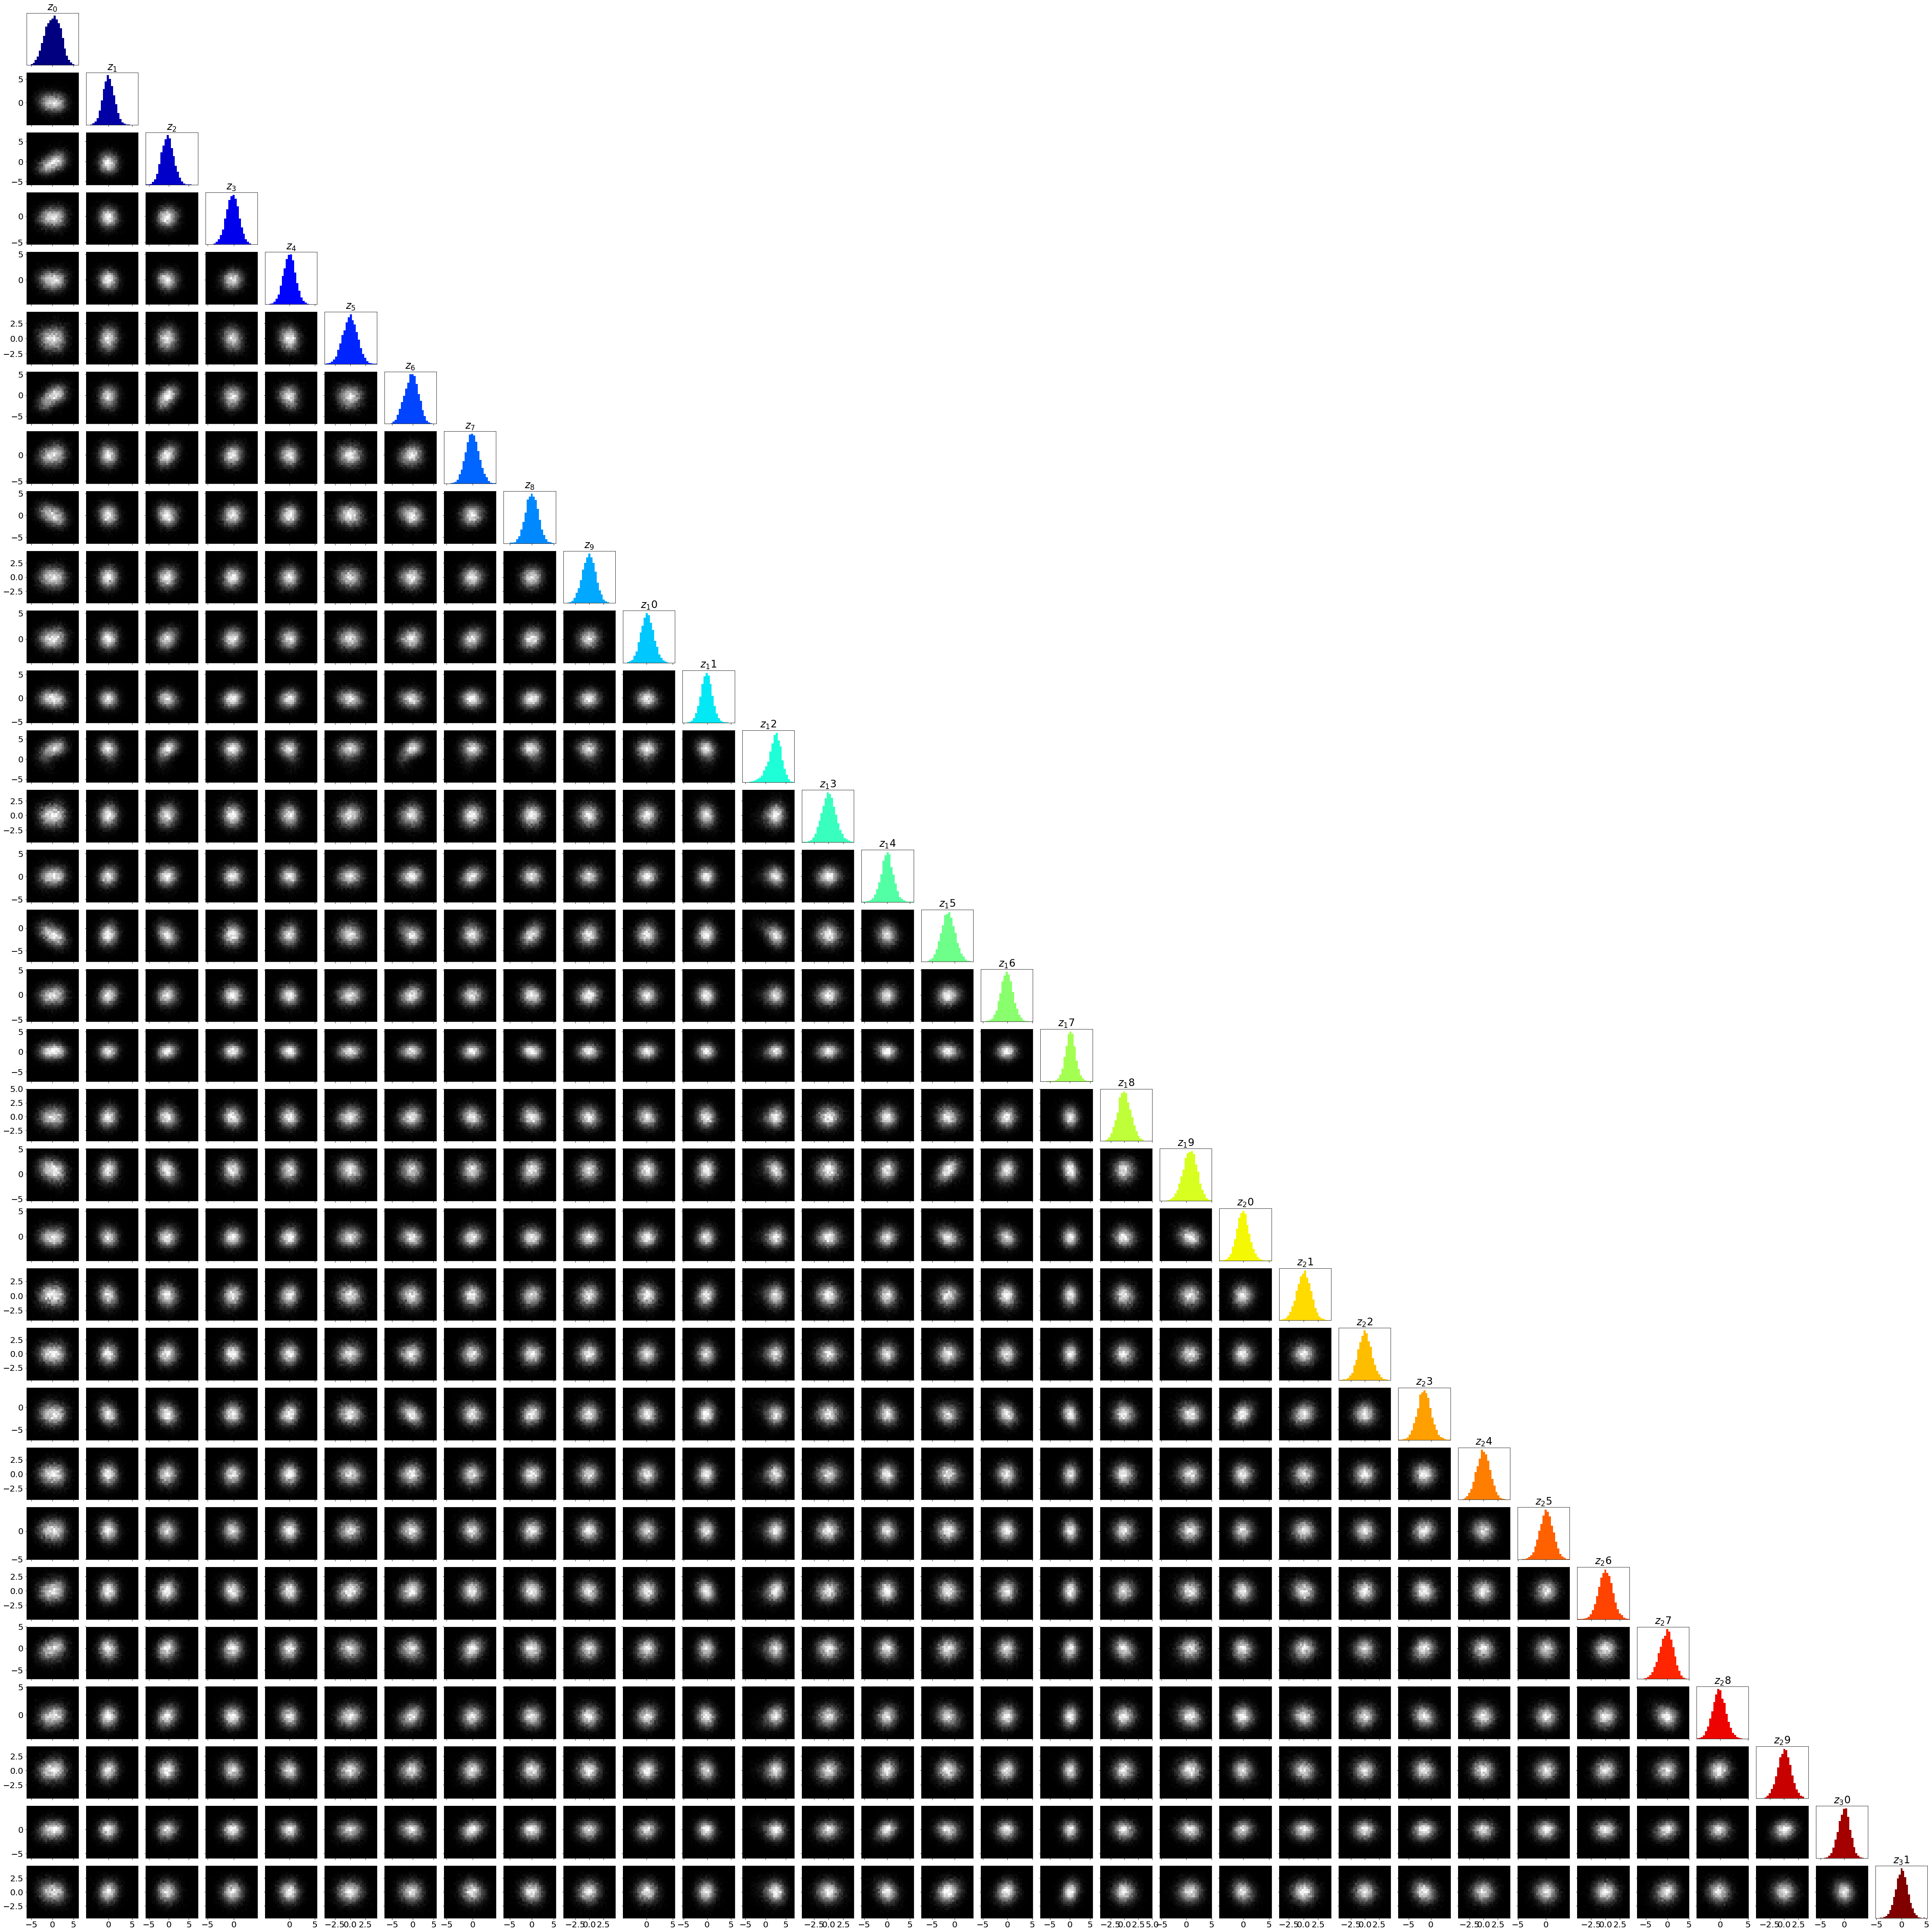

In [44]:
plot_corner_latent(z)

## LSST + Euclid all filters

In [34]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_LSST=[]
e=[]
counts = 0


N = 100

lum_in_simple_lsst_euclid = np.empty([N,N,],dtype='float32')
lum_out_simple_lsst_euclid= np.empty([N,N,], dtype='float32')


for j in range(100):
    input_vae = batch_gen_lsst_euclid.__getitem__(2)
    output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = batch_size)
    
    input_noisy = denorm(input_vae[0], bands_lsst_euclid, channel_last = True)
    input_noiseless = denorm(input_vae[1], bands_lsst_euclid, channel_last = True)
    output_vae = denorm (output_vae, bands_lsst_euclid, channel_last = True)
    
    for i in range (len(input_vae[0])):
        try:

            gal_image = galsim.Image(input_noiseless[i][:,:,6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i][:,:,6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            e.append([e_beta_in, e_beta_out])


            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = input_noiseless[i][:,:,6].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,6].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple_lsst_euclid[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple_lsst_euclid[j,i] = np.sum(masked_img_out_simple)
          
                    
        except :
            print('erreur')
            counts+=1
            pass
        continue

ellipticities_LSST_euclid = np.array(ellipticities)
e_beta_LSST_euclid = np.array(e)
print('number of errors: '+str(counts))

erreur
erreur
erreur
number of errors: 3


### Shape plots

Alpha 10-2

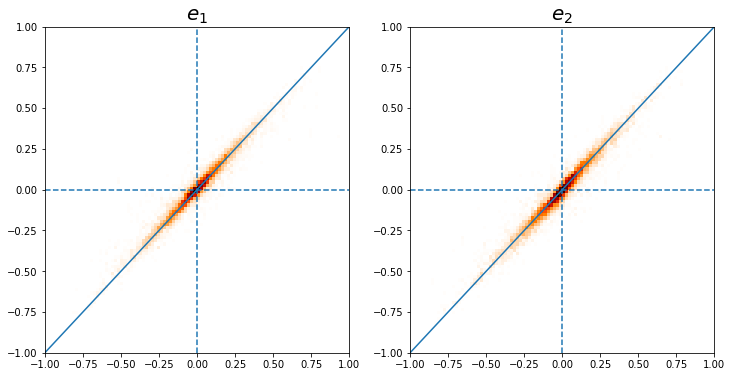

In [35]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST_euclid[:,0,i], ellipticities_LSST_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)#, color="w"
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w')
    axes[i].tick_params(axis='y')#, colors='w')

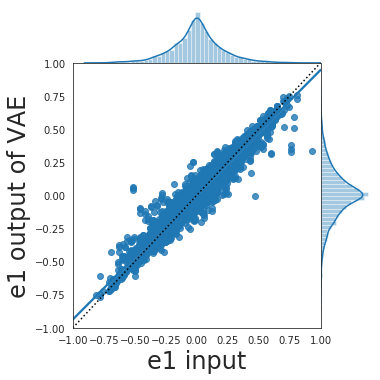

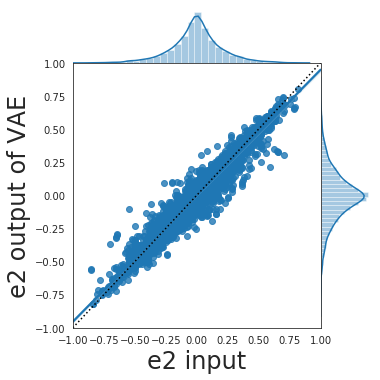

In [36]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_LSST_euclid[:,0,0], ellipticities_LSST_euclid[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_LSST_euclid[:,0,1], ellipticities_LSST_euclid[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

Text(0, 0.5, 'e of output galaxy')

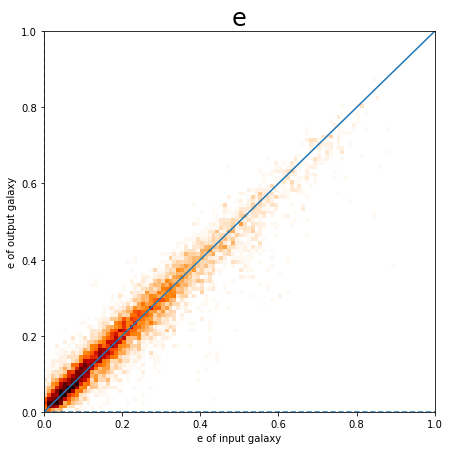

In [37]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta_LSST_euclid[:,0,0], e_beta_LSST_euclid[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

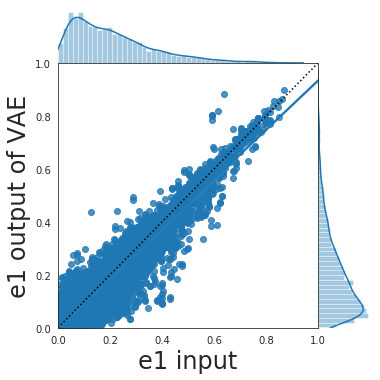

In [38]:
with sns.axes_style('white'):
            g = sns.jointplot(e_beta[:,0,0], e_beta[:,1,0], kind='reg',height =5,
                              xlim =[0, 1], ylim=[0, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(0, 1),
                            np.linspace(0, 1), ':k')


Text(0, 0.5, 'beta of output galaxy')

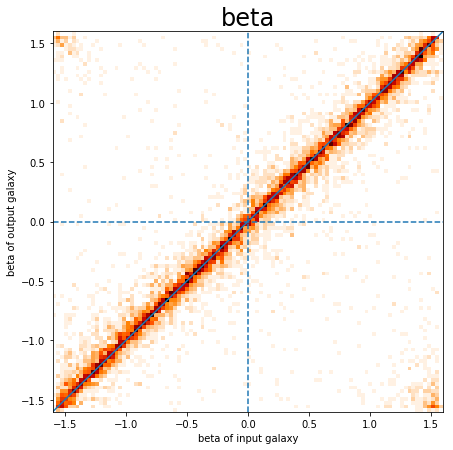

In [39]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta_LSST_euclid[:,0,1], e_beta_LSST_euclid[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

### Luminosity plots

In [40]:
lum_in_simple_lsst_euclid = np.concatenate(lum_in_simple_lsst_euclid)
lum_out_simple_lsst_euclid = np.concatenate(lum_out_simple_lsst_euclid)

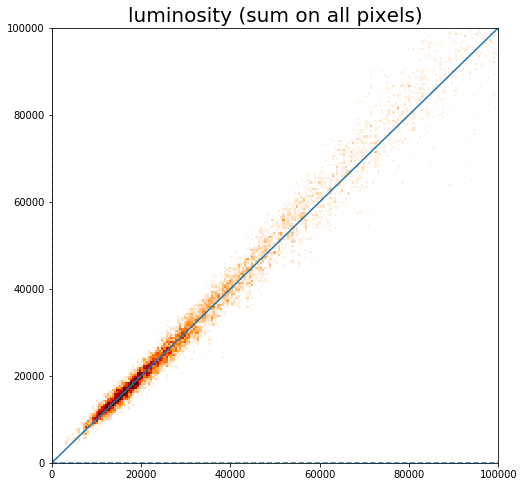

In [41]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

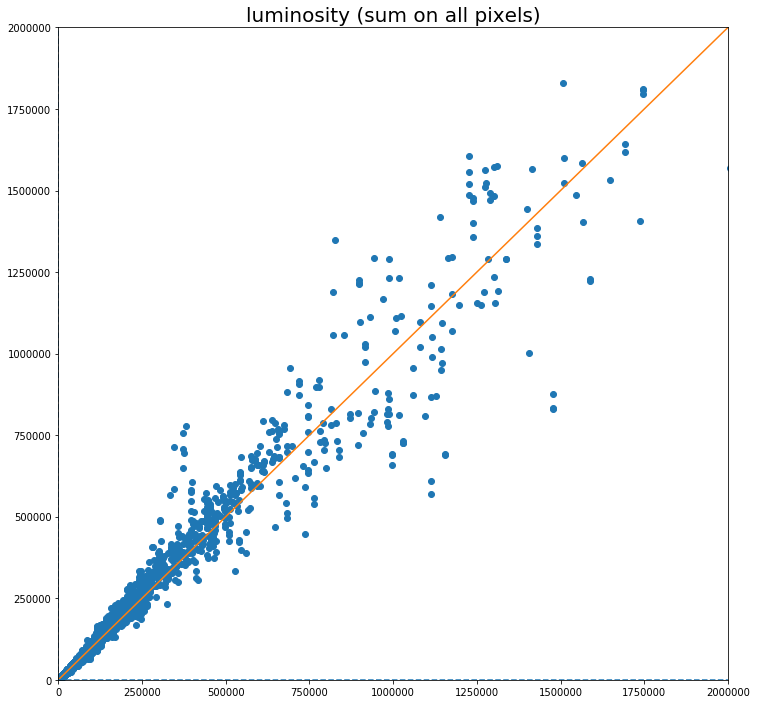

In [42]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

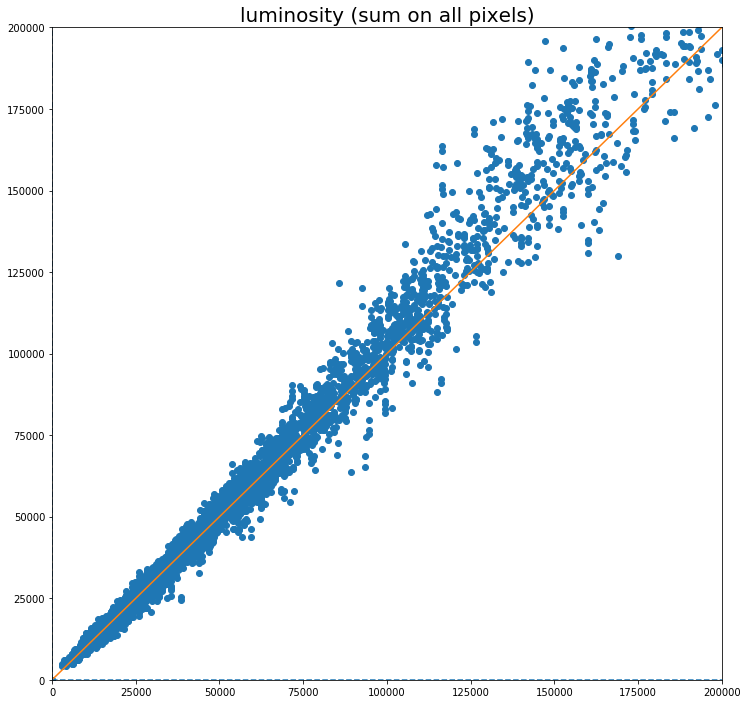

In [43]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple_lsst_euclid, lum_out_simple_lsst_euclid,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

### Corner plot latent space

In [55]:
latent_dim =32
epsilon_std = 1.0

a = batch_gen_lsst_euclid.__getitem__(2)
output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [56]:
z = []
for i in range (100):
    a = batch_gen_lsst_euclid.__getitem__(2)
    output_enc = encoder_LSST_EUCLID.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

z = np.concatenate(z, axis = 0)

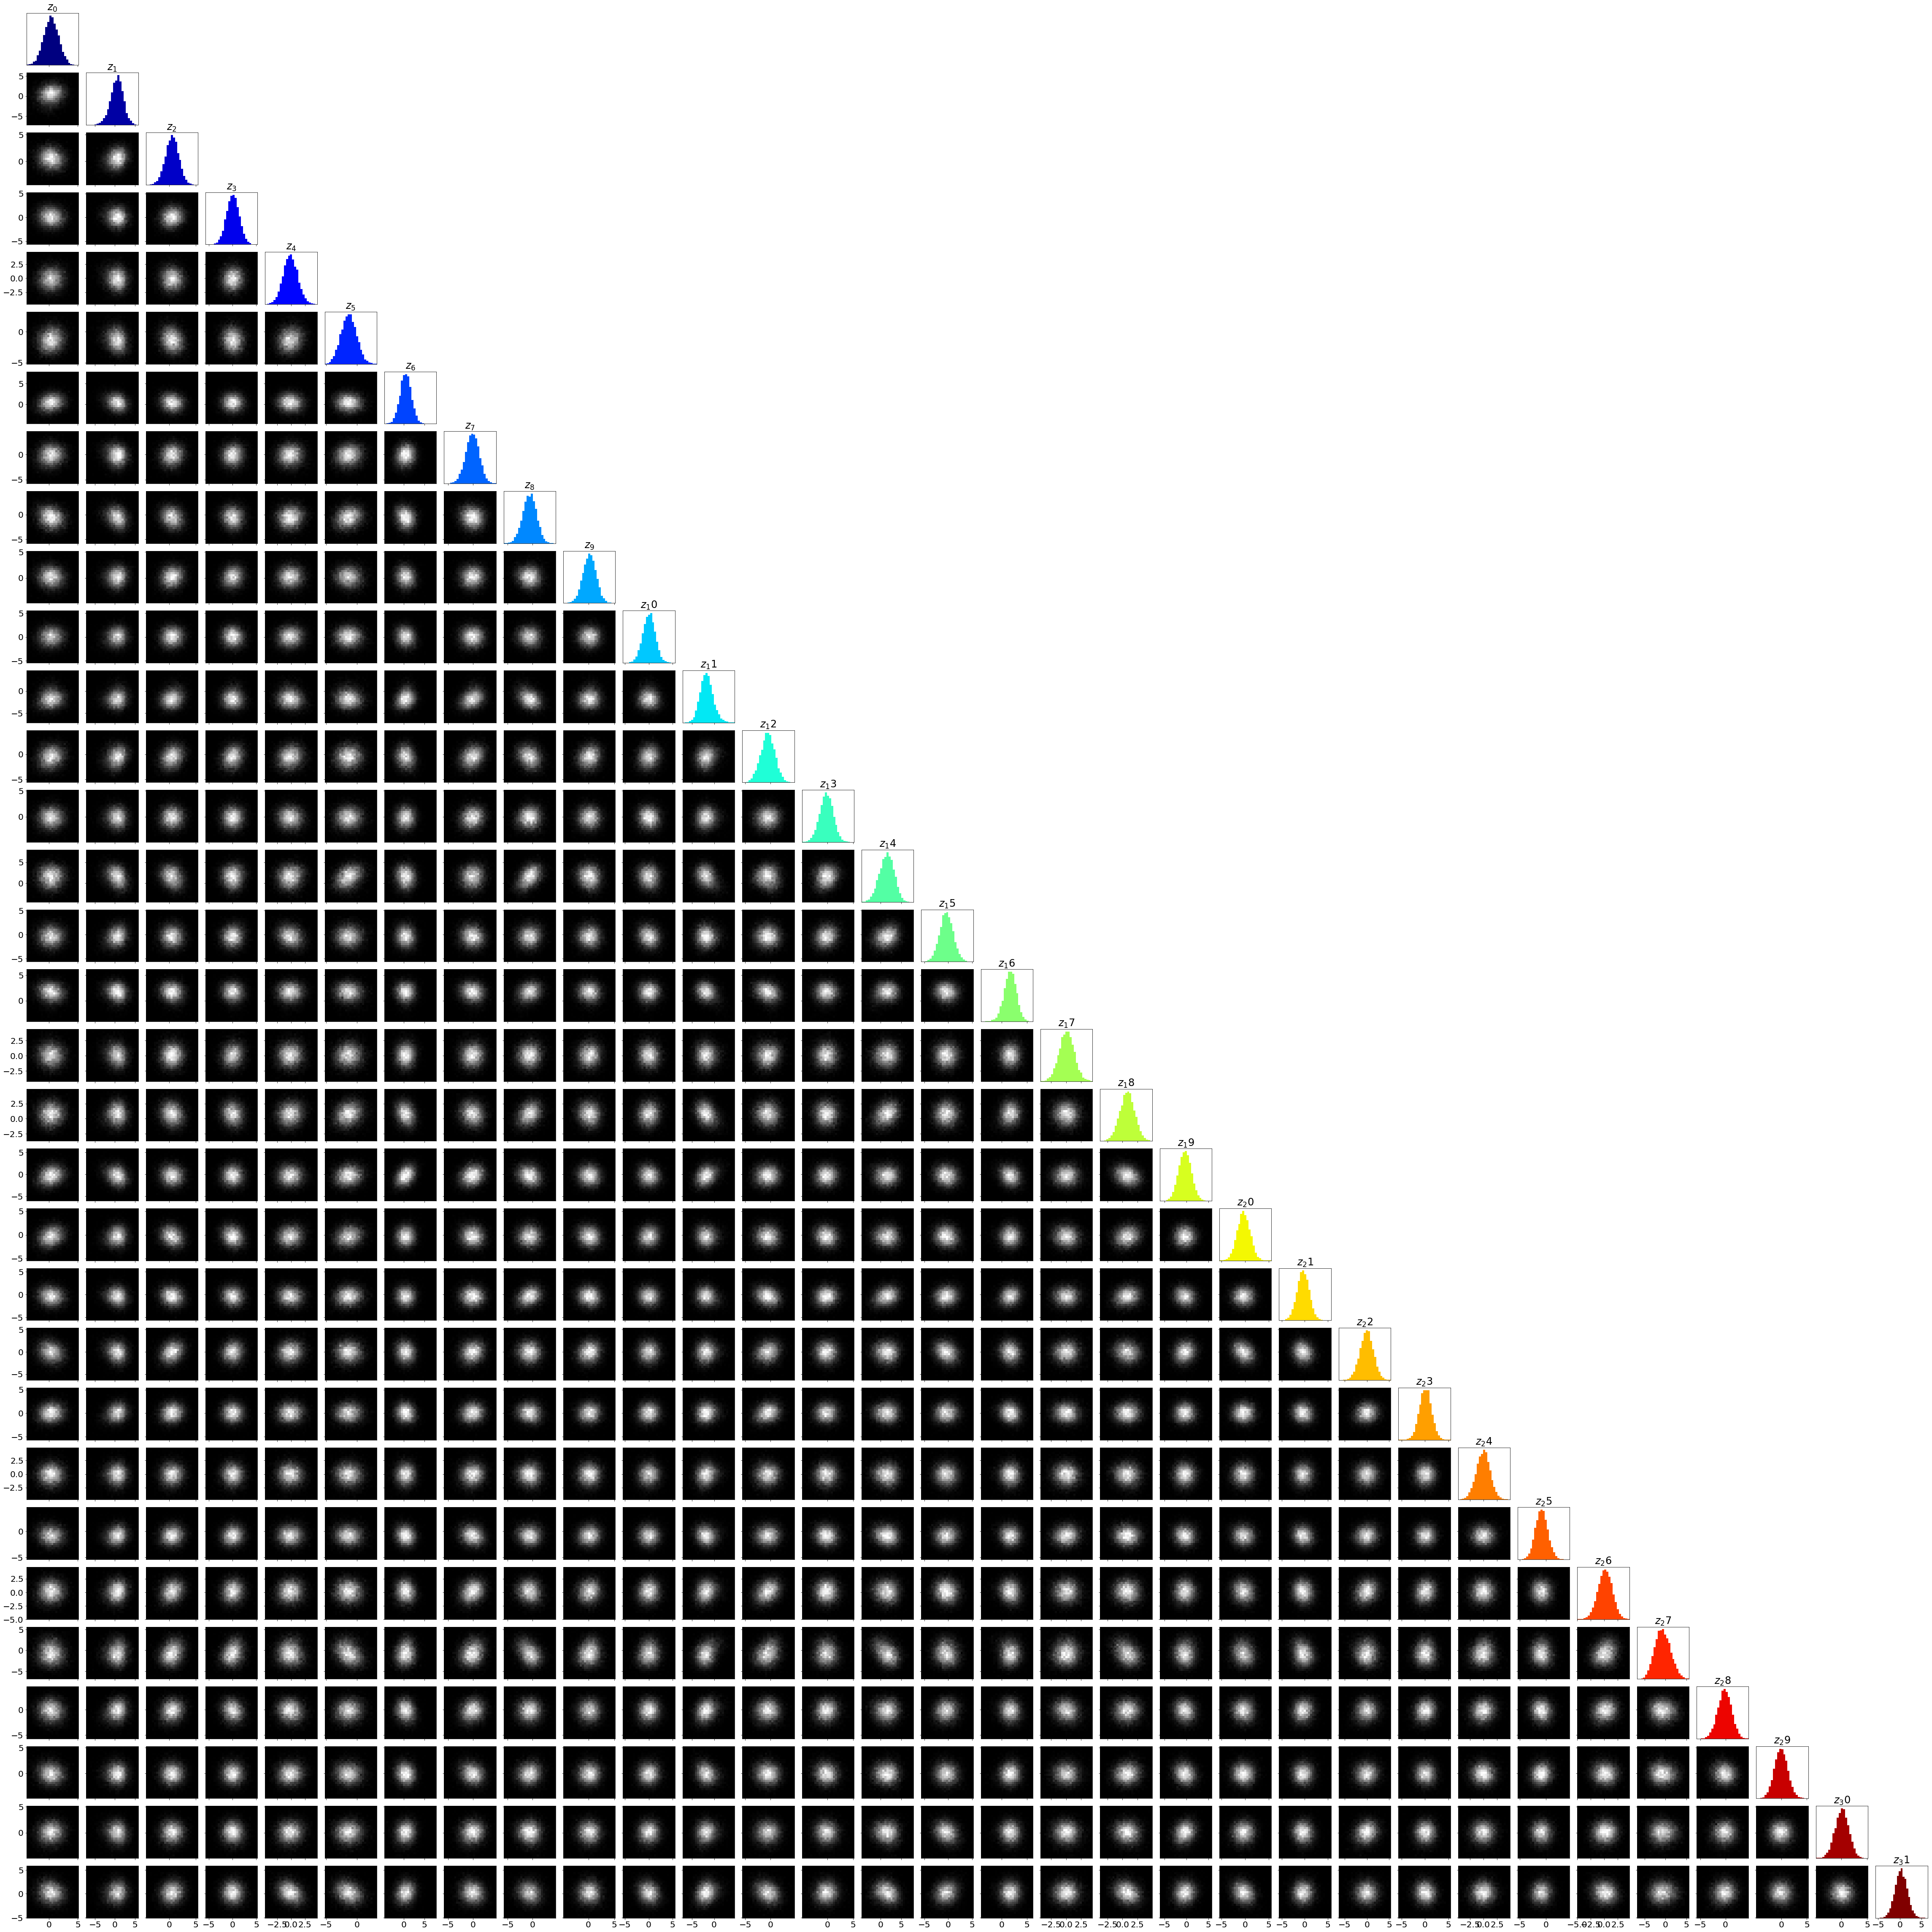

In [57]:
plot_corner_latent(z)

### N sampling of different galaxies for R band only

In [114]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [115]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

(100, 64, 64, 1)
0
0
1
2
3
4
5
6
7
8
9
(100, 64, 64, 1)
1
0
1
2
3
4
5
6
7
8
9
(100, 64, 64, 1)
2
0
1
2
3
4
5
6
7
8
9
0


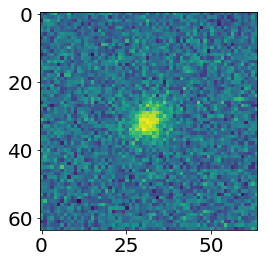

In [116]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_new.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    print(list_galsim_simple[1].shape)
    input_noiseless.append(denorm(list_galsim_simple[1], bands_r, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,0])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = vae_lsst_r_band_conv.predict(list_galsim_simple[0], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_r, channel_last = True)


        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,0])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            
    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [86]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,0])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    print(res_in_e1[k], res_in_e2[k])

0.024936603 -0.033879574
-0.0044743544 0.09465875
-0.035076052 0.050281707


Alpha from 10-4 to 10-6

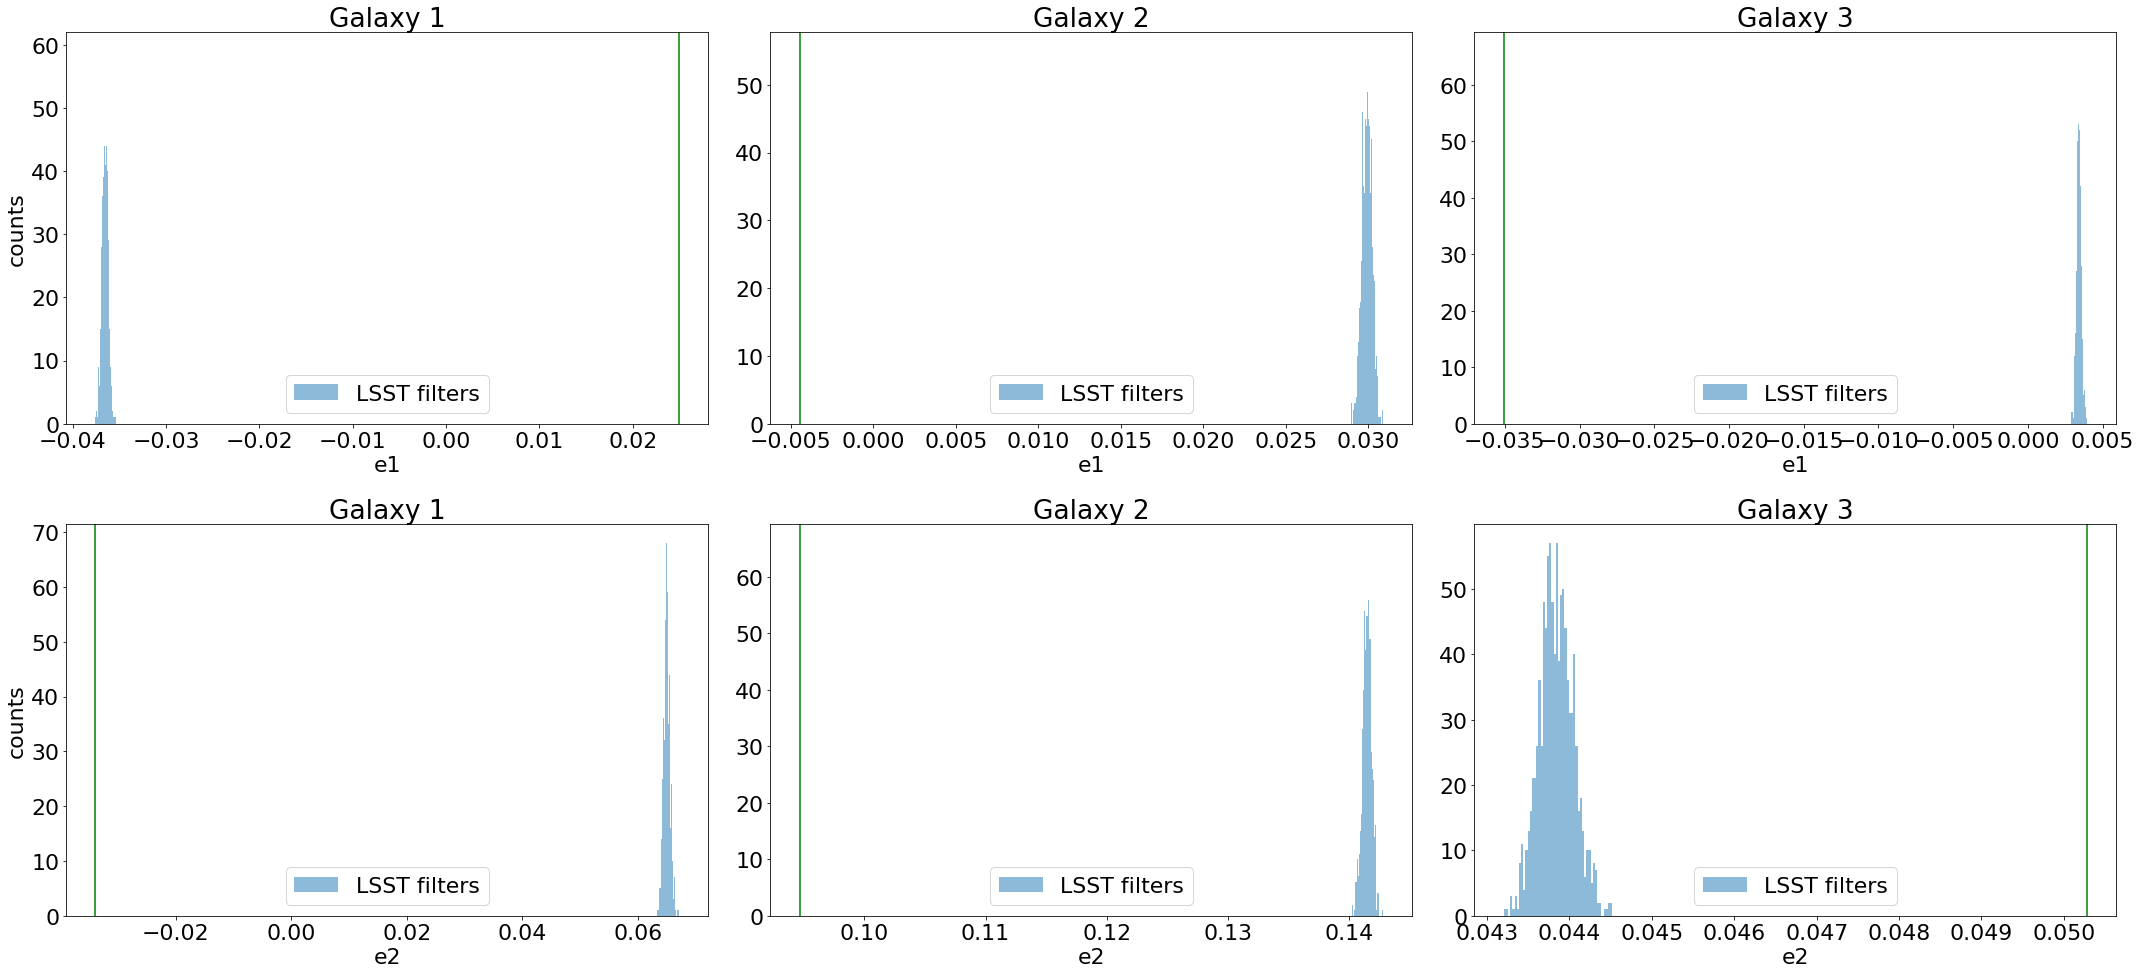

In [87]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(30,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
#ax.ticklabel_format(['y'],'sci')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

(-0.5, 63.5, 63.5, -0.5)

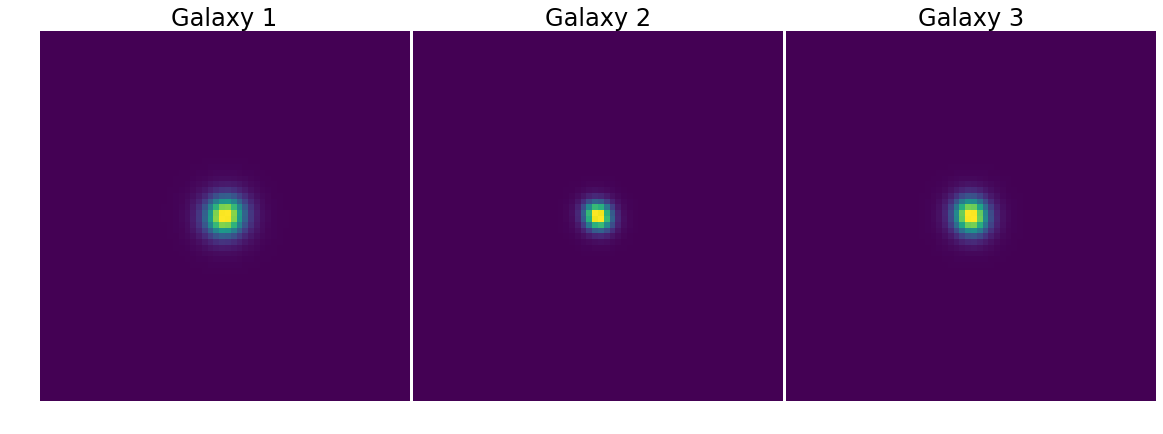

In [88]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(1, N_plot, figsize=(20, 7))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

ax = axes[0]
ax.imshow(input_noiseless[0][0][:,:,0])
ax.set_title('Galaxy 1')
ax.axis('off')

ax = axes[1]
ax.imshow(input_noiseless[1][0][:,:,0])
ax.set_title('Galaxy 2')
ax.axis('off')

ax = axes[2]
ax.imshow(input_noiseless[2][0][:,:,0])
ax.set_title('Galaxy 3')
ax.axis('off')

10-4

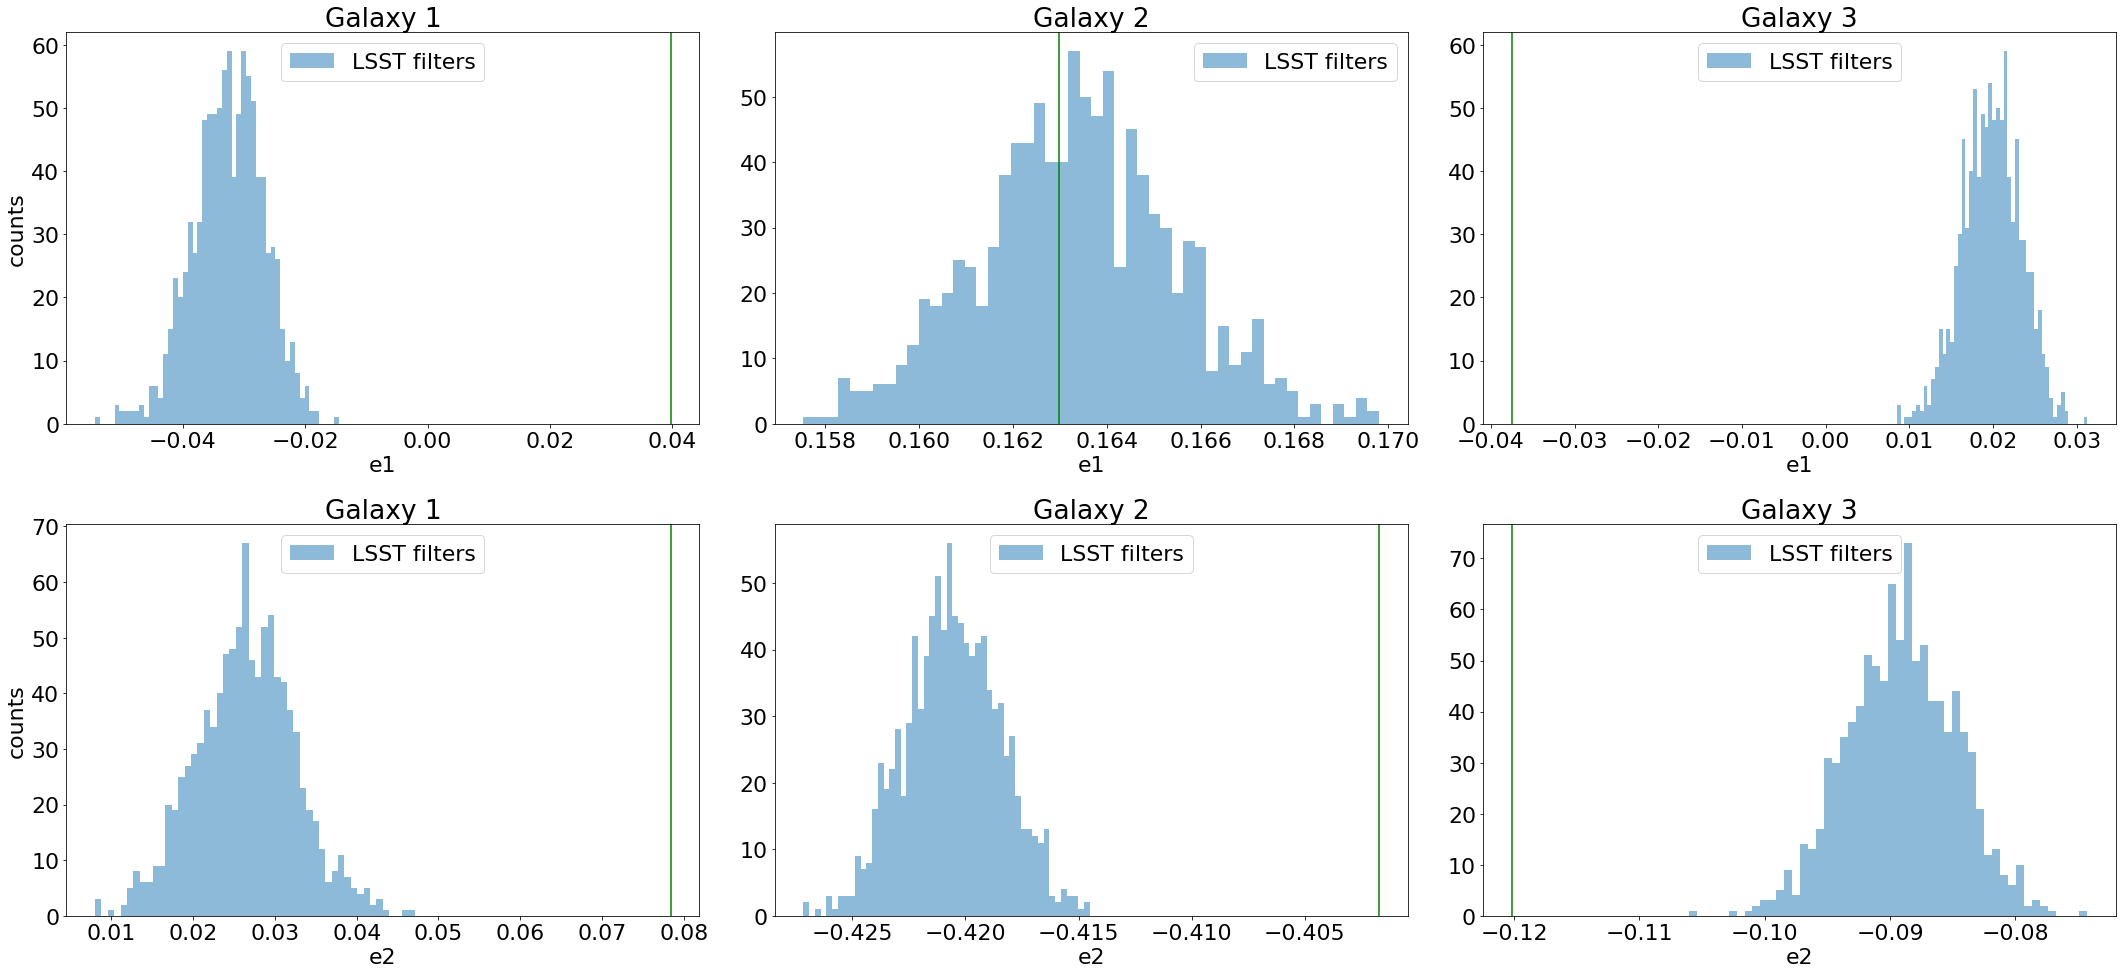

In [77]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(30,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
#ax.ticklabel_format(['y'],'sci')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

(-0.5, 63.5, 63.5, -0.5)

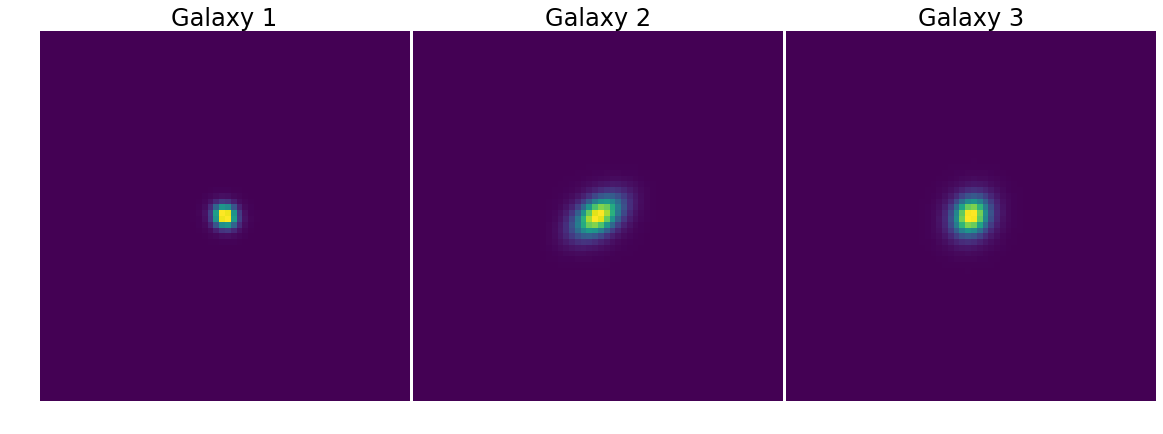

In [83]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(1, N_plot, figsize=(20, 7))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

ax = axes[0]
ax.imshow(input_noiseless[0][0][:,:,0])
ax.set_title('Galaxy 1')
ax.axis('off')

ax = axes[1]
ax.imshow(input_noiseless[1][0][:,:,0])
ax.set_title('Galaxy 2')
ax.axis('off')

ax = axes[2]
ax.imshow(input_noiseless[2][0][:,:,0])
ax.set_title('Galaxy 3')
ax.axis('off')

10-2

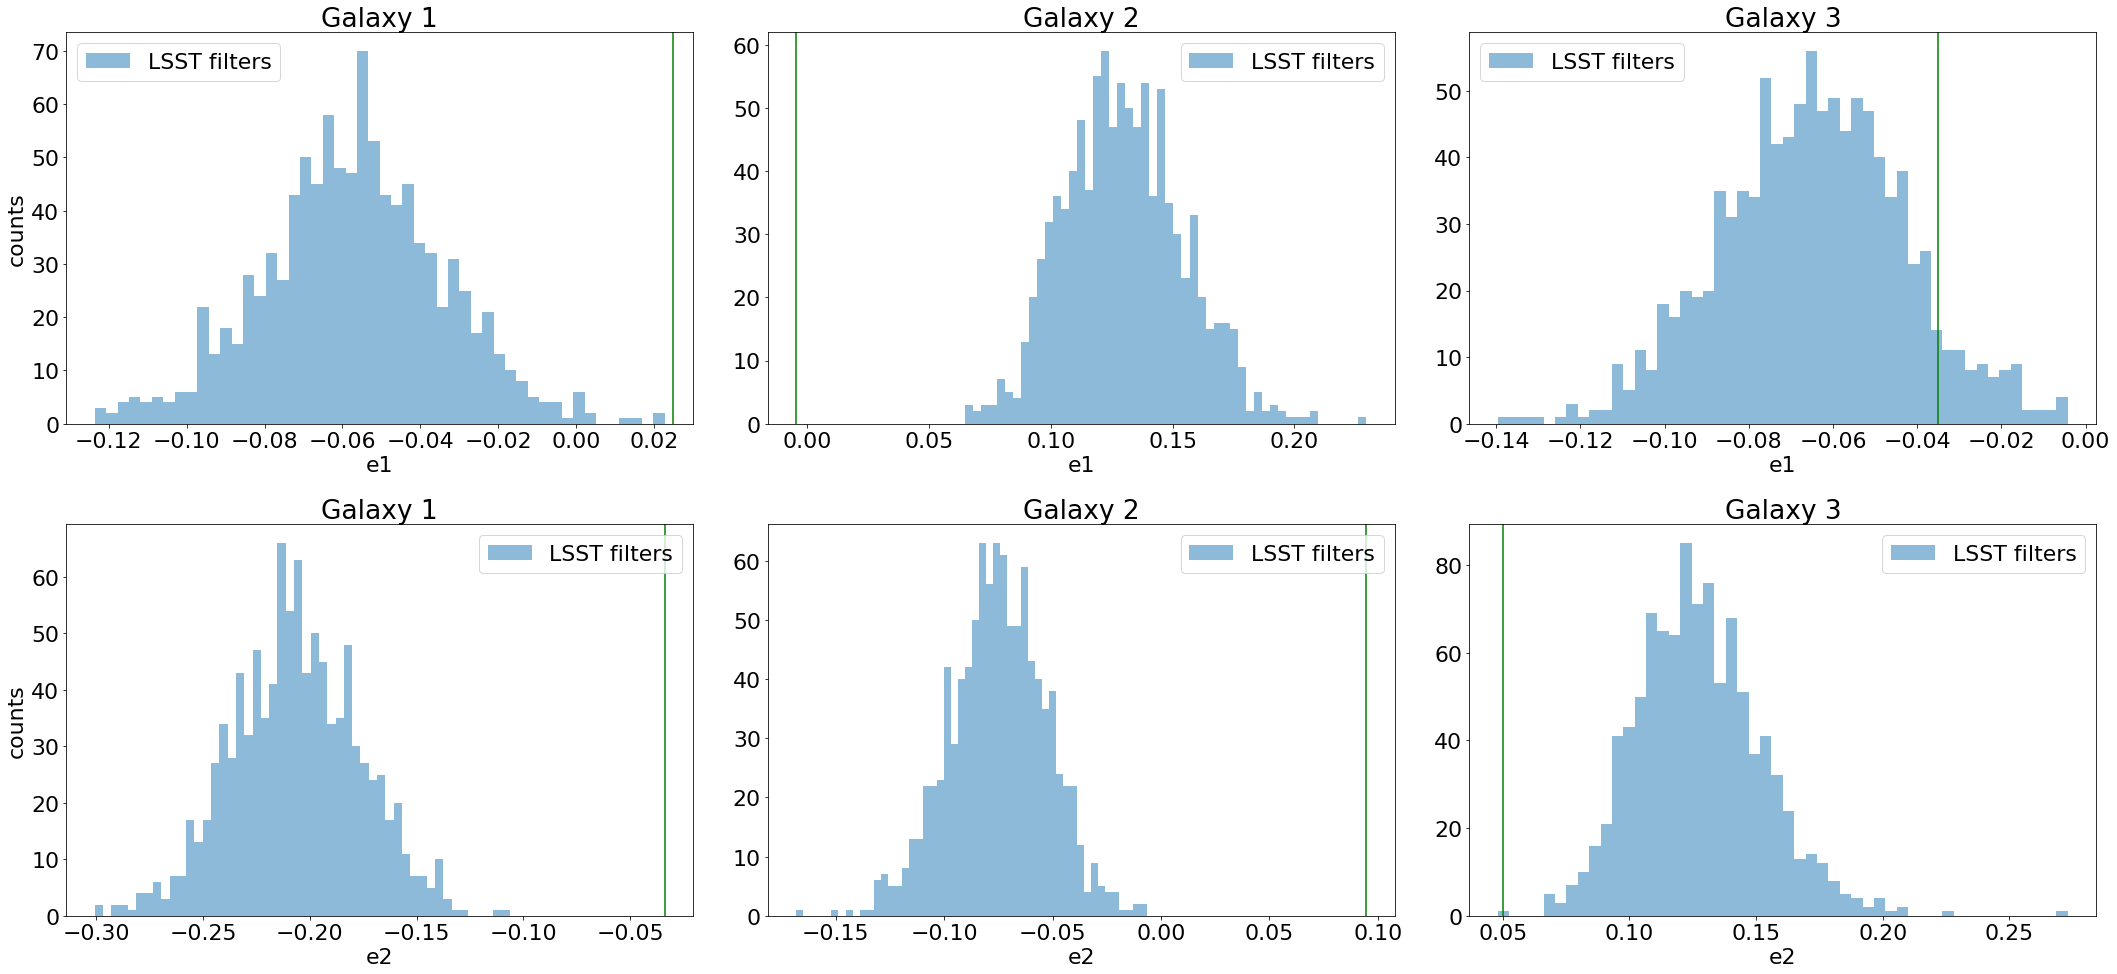

In [102]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(30,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
#ax.ticklabel_format(['y'],'sci')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

(-0.5, 63.5, 63.5, -0.5)

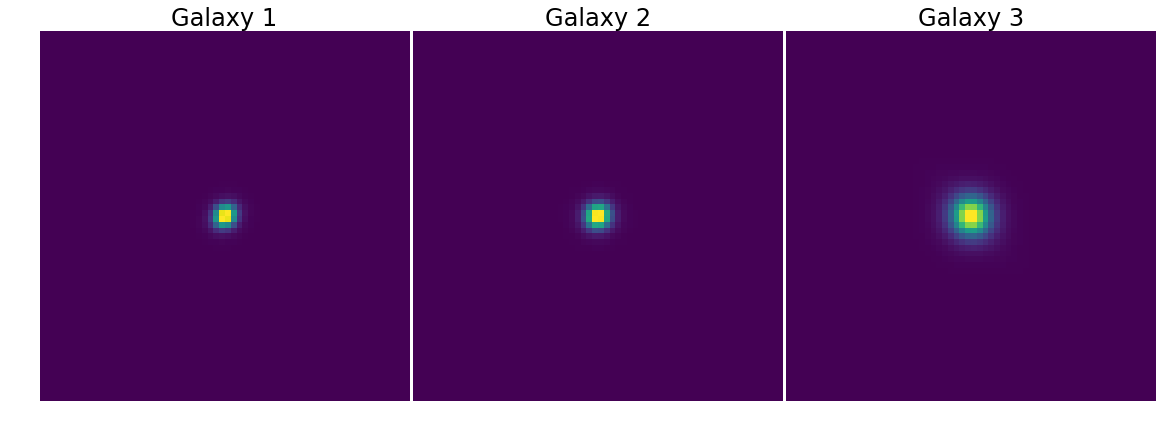

In [103]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(1, N_plot, figsize=(20, 7))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

ax = axes[0]
ax.imshow(input_noiseless[0][0][:,:,0])
ax.set_title('Galaxy 1')
ax.axis('off')

ax = axes[1]
ax.imshow(input_noiseless[1][0][:,:,0])
ax.set_title('Galaxy 2')
ax.axis('off')

ax = axes[2]
ax.imshow(input_noiseless[2][0][:,:,0])
ax.set_title('Galaxy 3')
ax.axis('off')

Alpha 10-1

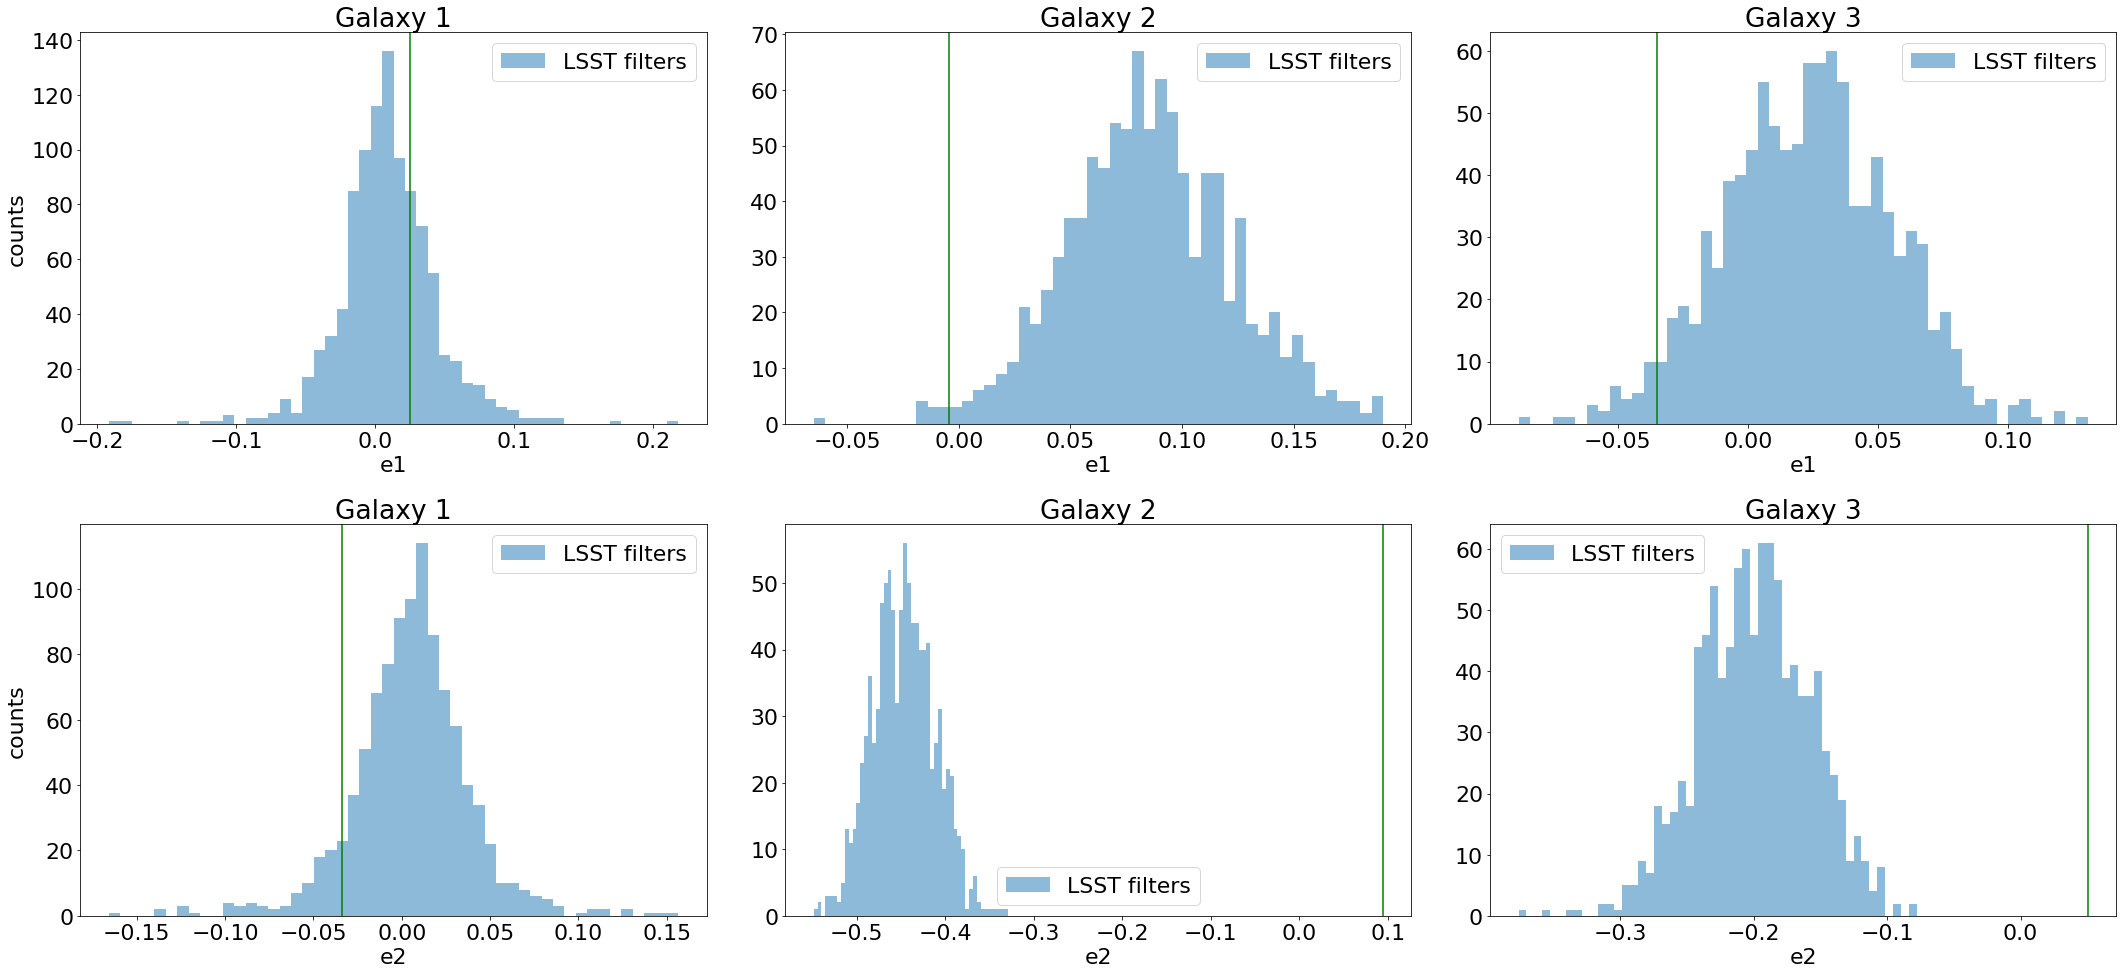

In [117]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(30,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
#ax.ticklabel_format(['y'],'sci')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

(-0.5, 63.5, 63.5, -0.5)

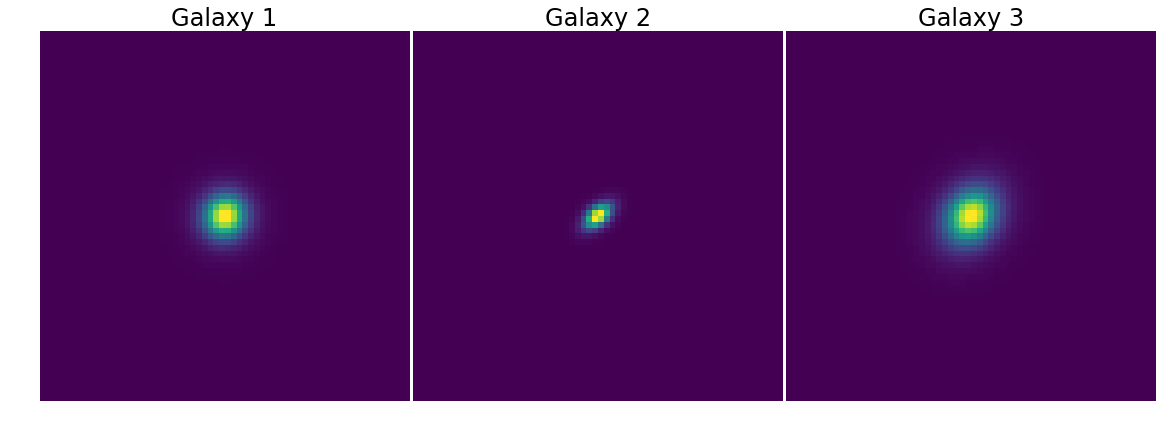

In [118]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(1, N_plot, figsize=(20, 7))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

ax = axes[0]
ax.imshow(input_noiseless[0][0][:,:,0])
ax.set_title('Galaxy 1')
ax.axis('off')

ax = axes[1]
ax.imshow(input_noiseless[1][0][:,:,0])
ax.set_title('Galaxy 2')
ax.axis('off')

ax = axes[2]
ax.imshow(input_noiseless[2][0][:,:,0])
ax.set_title('Galaxy 3')
ax.axis('off')

### N sampling of different galaxies for LSST only

0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
0


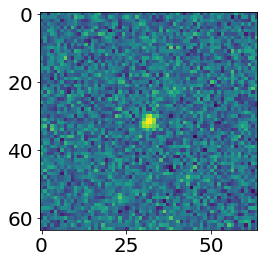

In [263]:
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e = np.empty([N,nb_of_samplings*batch_size], dtype='float32')

gal = []
input_noiseless = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    input_noiseless.append(denorm(list_galsim_simple[1], bands_lsst, channel_last = True))
    
    plt.imshow(list_galsim_simple[0][0][:,:,2])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    #try: 
    print(i)
    for j in range (nb_of_samplings):
        print(j)
        output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0][:,:,:], batch_size = batch_size)
        output_vae_list_lsst = denorm (output_vae_list_lsst, bands_lsst, channel_last = True)


        for t in range (batch_size):
            img_out_simple = galsim.Image(output_vae_list_lsst[t][:,:,2])
            res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
            res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            res_out_lsst_e[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e   
            
    #except :
    #    err_count +=1
    #    print('erreur')
    #    pass
    #continue
            
print(err_count)

In [264]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')
res_in_e = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(input_noiseless[k][0][:,:,2])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    res_in_e[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e
    print(res_in_e1[k], res_in_e2[k])

0.07668989 0.14417091
0.011299635 0.193726
-0.082198076 -0.21085948


In [1]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(30,14))

ax = axes[0,0]
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
#ax.ticklabel_format(['y'],'sci')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')

ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)



fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0)

max_x = np.max((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
min_x = np.min((res_out_lsst_e[0]- res_in_e[0], res_out_lsst_e[1]- res_in_e[2], res_out_lsst_e[2]- res_in_e[2]))
max_lim = np.max((np.abs(max_x), np.abs(min_x)))
print(max_lim)

ax = axes[0,0]
_ = ax.imshow(gal[0][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[0,1]
_ = ax.hist(res_out_lsst_e[0]- res_in_e[0], bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[0]-res_in_e[0]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[0]-res_in_e[0])+0.01, 20, str(np.mean(res_out_lsst_e[0]-res_in_e[0])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.legend()
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])

ax = axes[1,0]
_ = ax.imshow(gal[1][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[1,1]
_ = ax.hist(res_out_lsst_e[1]- res_in_e[1], bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[1]-res_in_e[1]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[1]-res_in_e[1])+0.01, 20, str(np.mean(res_out_lsst_e[1]-res_in_e[1])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.set_yticklabels([])

ax = axes[2,0]
_ = ax.imshow(gal[2][:,:,2])
#ax.axis('off')
ax.set_yticklabels([])
ax.set_xticklabels([])

ax = axes[2,1]
_ = ax.hist(res_out_lsst_e[2]-res_in_e[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
ax.axvline(np.mean(res_out_lsst_e[2]-res_in_e[2]),color='r',ls='--')
ax.text(np.mean(res_out_lsst_e[2]-res_in_e[2])+0.01, 20, str(np.mean(res_out_lsst_e[2]-res_in_e[2])), fontsize =15, color='r')
ax.set_xlabel('e')
ax.set_xlim(-max_lim, max_lim)
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_yticklabels([])


0
0
1
2
3
4
5
6
7
8
9
1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
0


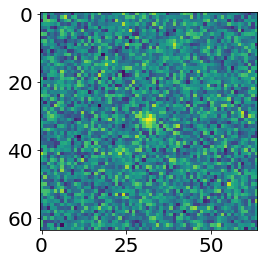

In [267]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][1])
    
    plt.imshow(list_galsim_simple[0][0][:,:,6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0][:,:,:,6].reshape((batch_size,64,64,1)), batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0][:,:,:,4:], batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,:,:,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,:,:,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [269]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k][:,:,6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

0.023879027 -0.26258844
0.17723005 -0.19179021
-0.29881474 -0.59689546


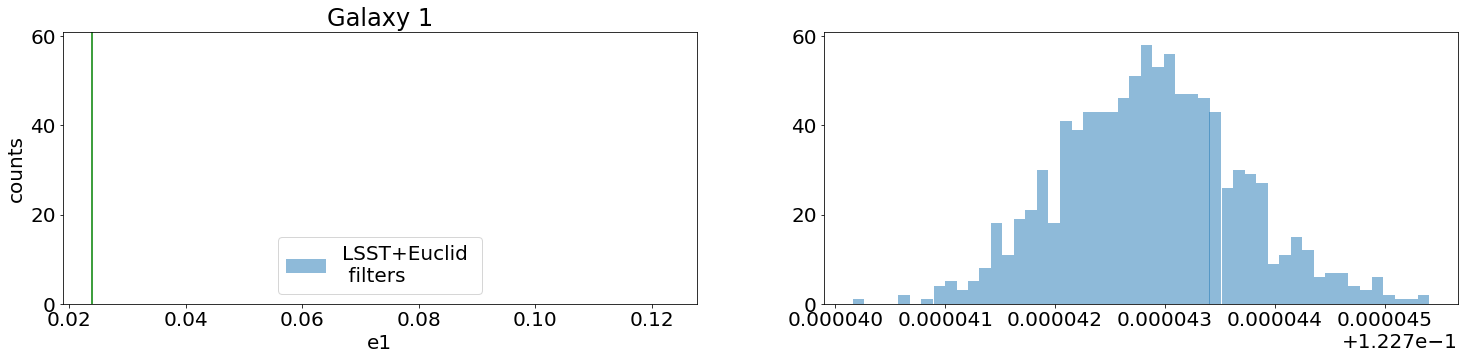

In [278]:
fig, axes = plt.subplots(1,2, figsize=(25,5))

ax = axes[0]
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[1]
_ = ax.hist(res_out_lsst_euclid_e1[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)



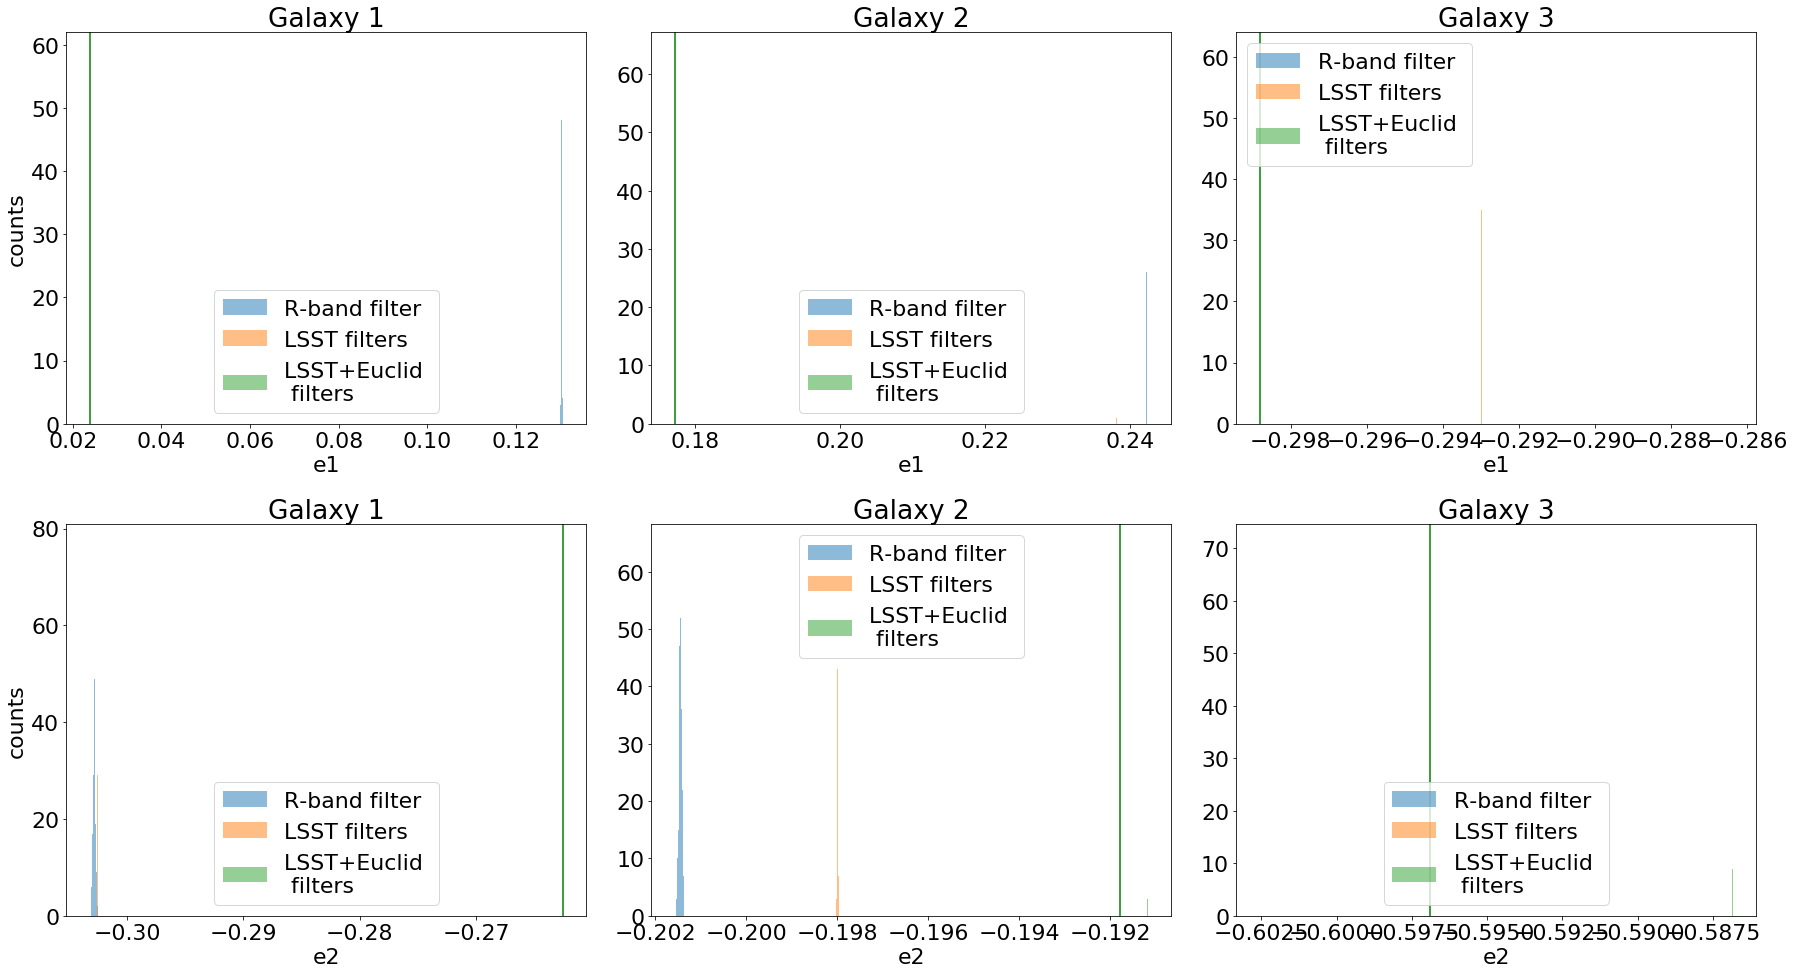

In [270]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

NameError: name 'ellipticities_test' is not defined

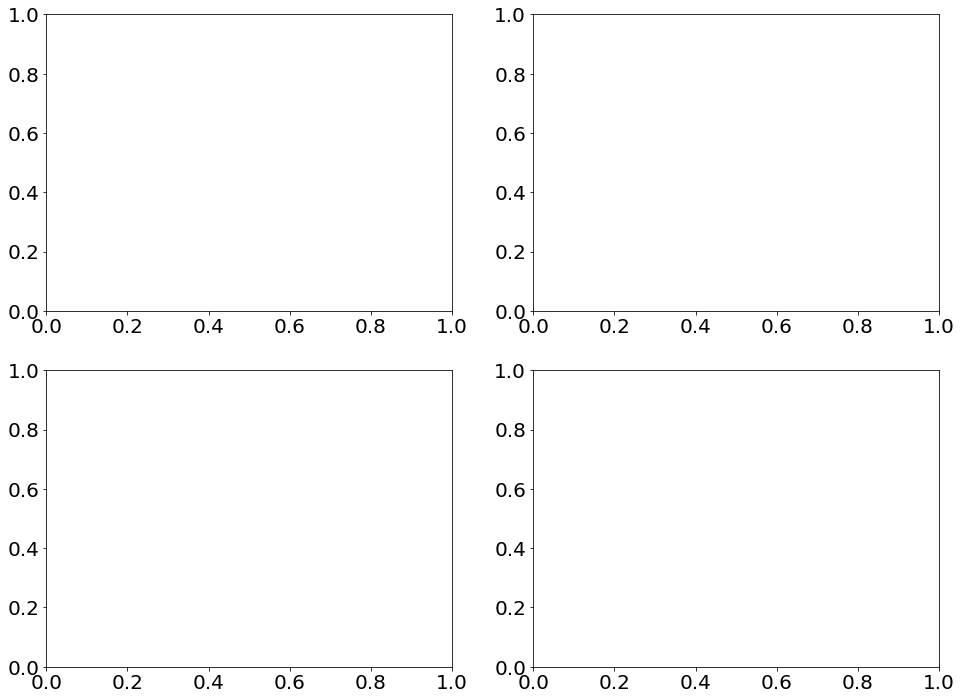

In [271]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2, 2, figsize=(16, 12))
_ = axes[0,0].hist(ellipticities_test[:,0,0], bins = 100 , histtype='stepfilled')
axes[0,0].set_title('e1 distribution LSST')
axes[0,0].set_ylim(0, 65)
_ = axes[0,1].hist(ellipticities_test[:,1,0], bins = 100 , histtype='stepfilled')
axes[0,1].set_title('e1 distribution VIS (Euclid)')
axes[0,1].set_ylim(0, 65)
_ = axes[1,0].hist(ellipticities_test[:,0,1], bins = 100 , histtype='stepfilled')
axes[1,0].set_title('e2 distribution LSST')
axes[1,0].set_ylim(0, 65)
_ = axes[1,1].hist(ellipticities_test[:,1,1], bins = 100 , histtype='stepfilled')
axes[1,1].set_title('e2 distribution VIS (Euclid)')
axes[1,1].set_ylim(0, 65)

## Comparison with VAE R filter only

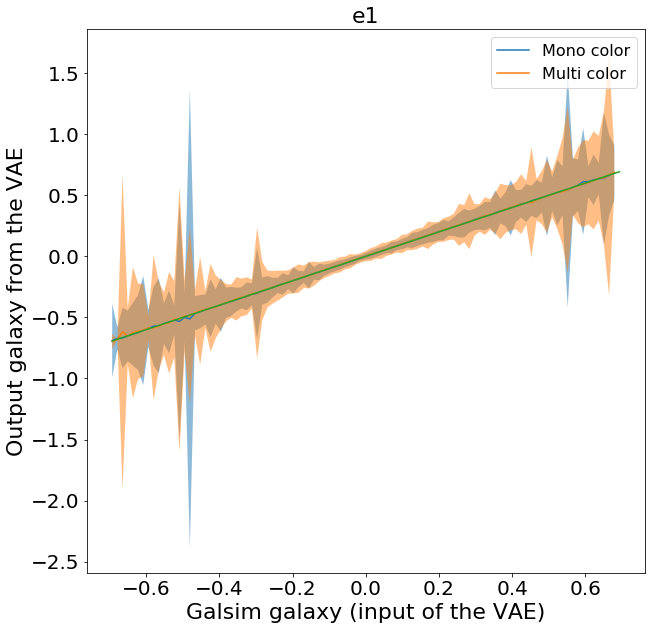

In [200]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,0],ellipticities_r_band[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

plt.plot(mid, mid)

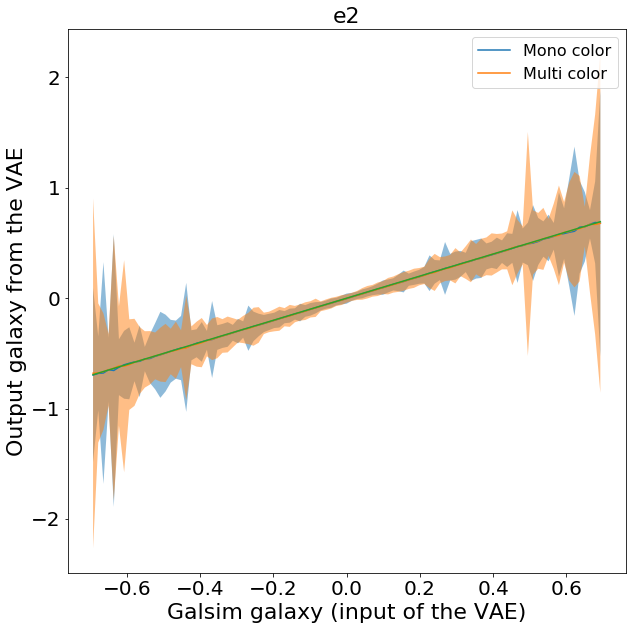

In [201]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,1],ellipticities_r_band[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

#### LSST compared to LSST+EUCLID

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


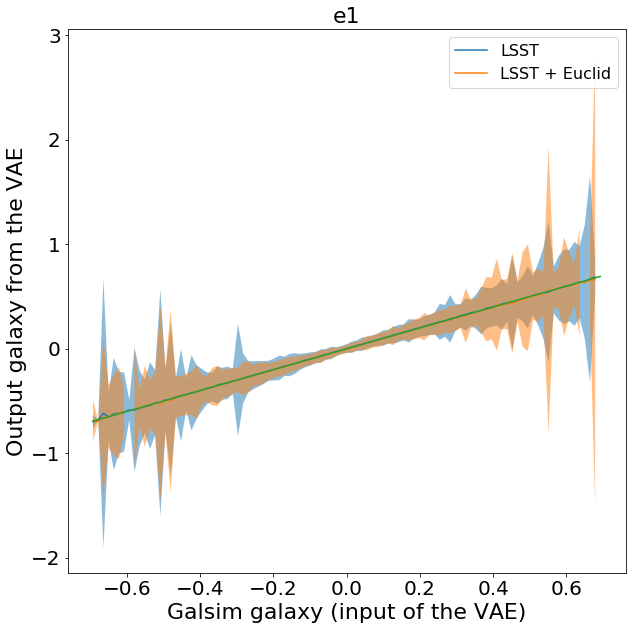

In [202]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,0],ellipticities_LSST[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,0],ellipticities_LSST_euclid[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

#plt.spines['bottom'].set_color('w')
#plt.spines['right'].set_color('w')
#plt.spines['left'].set_color('w')
#plt.spines['top'].set_color('w')
#plt.xaxis.label.set_color('w')
#plt.tick_params(axis='x', colors='w')
#plt.tick_params(axis='y', colors='w')

plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


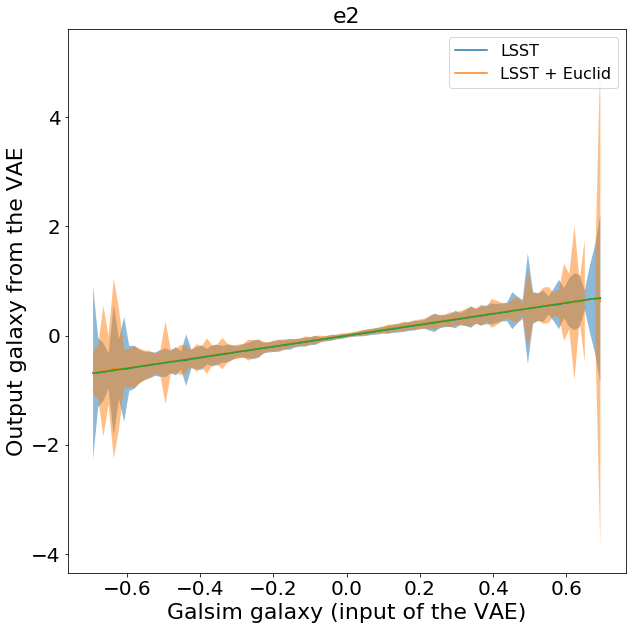

In [205]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_LSST[:,0,1],ellipticities_LSST[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,1],ellipticities_LSST_euclid[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

## Flux comparison

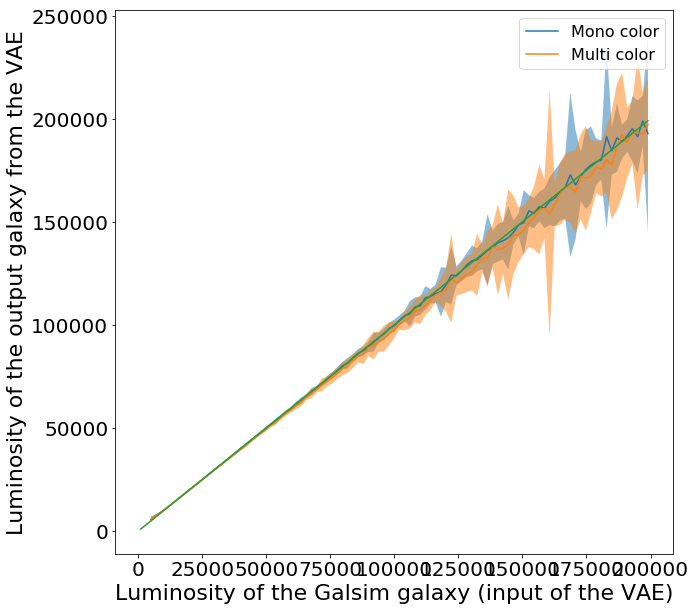

In [287]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 200000, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_r,lum_out_simple_r,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


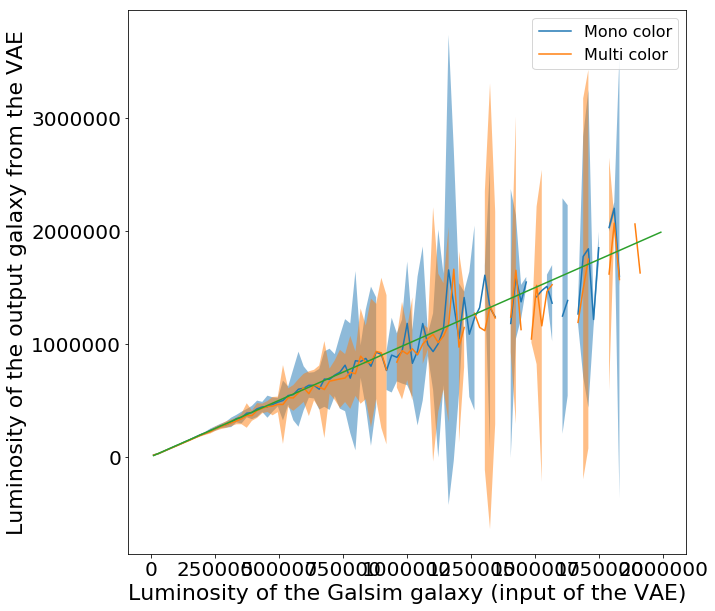

In [286]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 2000000, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_r,lum_out_simple_r,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

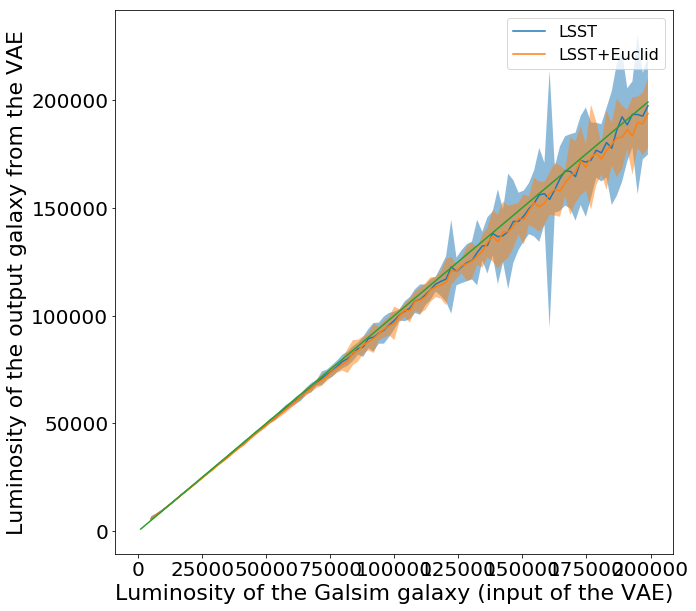

In [290]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 200000, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst_euclid,lum_out_simple_lsst_euclid,bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST+Euclid')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


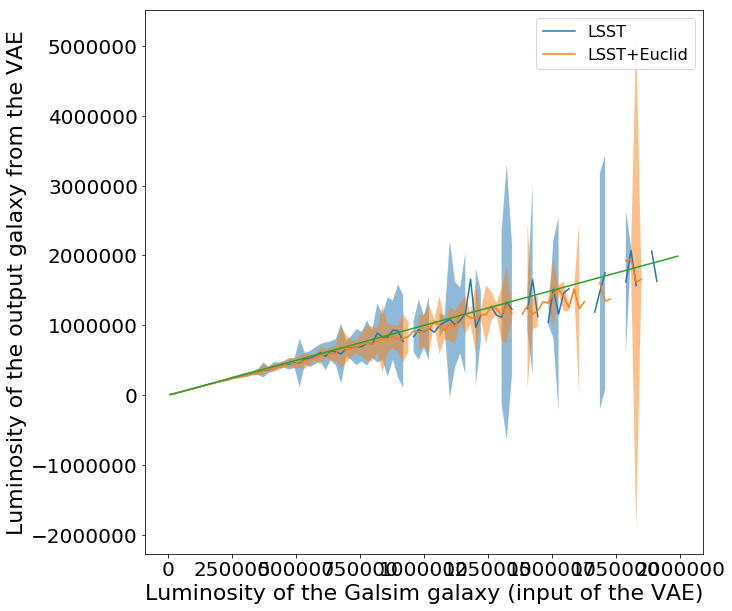

In [291]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 2000000, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple_lsst,lum_out_simple_lsst,bins)
mean_multi, var_multi = mean_var(lum_in_simple_lsst_euclid,lum_out_simple_lsst_euclid,bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST+Euclid')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)